# Image Classification of ATLAS Calorimeter Topo-Clusters: Let's Try 2D CNNs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/AL/Phd/maxml/caloml-atlas/'
plotpath = path_prefix+'classifier/Plots/'
modelpath = path_prefix+'classifier/Models/'

In [3]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

Using TensorFlow backend.


In [4]:
inputpath = path_prefix+'inputs/'
rootfiles = ["pi0", "piplus", "piminus"]

trees, pdata = mu.setupPionData(inputpath, rootfiles)

In [5]:
np0 = len(pdata['pi0'])
npp = len(pdata['piplus'])
npm = len(pdata['piminus'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
print("Total: {}".format(np0+npp+npm))

Number of pi0 events: 263891
Number of pi+ events: 435967
Number of pi- events: 434627
Total: 1134485


In [6]:
pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, flatten = False)
        for layer in mu.cell_meta
    }
    for ifile, itree in trees.items()
}

## Can we train the CNN still?

In [7]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow import keras as keras

In [8]:
import tensorflow as tf

gpu_list = ["/gpu:0"]
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [9]:
training_classes = ['pi0','piplus']
# create train/validation/test subsets containing 70%/10%/20%
# of events from each type of pion event
pdata_merged, pcells_merged, plabels = mu.createTrainingDatasets(training_classes, pdata, pcells)

In [10]:
pcells_merged_reshaped = mu.reshapeSeparateCNN(pcells_merged)

In [11]:
# not sure how useful these 1,1 filters are?
# may need 'shallower' networks instead for the further networks
filters = {
    'EMB1': (2,4), 
    'EMB2': (4,4), 
    'EMB3': (4,2), 
    'TileBar0': (2,2), 
    'TileBar1': (2,2), 
    'TileBar2': (1,1)
}
pools2 = {
    'EMB1': (2,2), 
    'EMB2': (2,2), 
    'EMB3': (1,1), 
    'TileBar0': (1,1), 
    'TileBar1': (1,1), 
    'TileBar2': (1,1)
}

In [12]:
def cnn_model_layers(layer):
    print(layer)
    # create model
    with strategy.scope():
        model = Sequential()
        model.add(Convolution2D(32, filters[layer], input_shape=(1,mu.cell_meta[layer]['len_eta'],mu.cell_meta[layer]['len_phi']), activation='relu', data_format = 'channels_first'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        # model.add(Convolution2D(16, (2, 2), activation='relu'))
        model.add(Convolution2D(16, pools2[layer], activation='relu'))
        model.add(MaxPool2D(pool_size=pools2[layer]))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model

In [13]:
models = {
    layer: cnn_model_layers(layer)
    for layer in mu.cell_meta
}

EMB1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
EMB2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
EMB3
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
TileBar0
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0'

In [14]:
history = {
    layer: models[layer].fit(pcells_merged_reshaped[layer][pdata_merged.train], 
                                plabels[pdata_merged.train], 
                                validation_data=(pcells_merged_reshaped[layer][pdata_merged.val], plabels[pdata_merged.val]),                                   epochs=100, batch_size=200*ngpu, verbose=2)
    for layer in mu.cell_meta
}

Train on 489899 samples, validate on 69988 samples
Epoch 1/100
489899/489899 - 23s - loss: 0.3992 - acc: 0.8221 - val_loss: 0.3453 - val_acc: 0.8615
Epoch 2/100
489899/489899 - 16s - loss: 0.3051 - acc: 0.8812 - val_loss: 0.2798 - val_acc: 0.8942
Epoch 3/100
489899/489899 - 16s - loss: 0.2762 - acc: 0.8936 - val_loss: 0.2705 - val_acc: 0.8966
Epoch 4/100
489899/489899 - 15s - loss: 0.2669 - acc: 0.8972 - val_loss: 0.2712 - val_acc: 0.8967
Epoch 5/100
489899/489899 - 16s - loss: 0.2599 - acc: 0.9006 - val_loss: 0.2635 - val_acc: 0.8990
Epoch 6/100
489899/489899 - 16s - loss: 0.2558 - acc: 0.9024 - val_loss: 0.2621 - val_acc: 0.9005
Epoch 7/100
489899/489899 - 16s - loss: 0.2516 - acc: 0.9039 - val_loss: 0.2527 - val_acc: 0.9045
Epoch 8/100
489899/489899 - 16s - loss: 0.2493 - acc: 0.9051 - val_loss: 0.2507 - val_acc: 0.9061
Epoch 9/100
489899/489899 - 16s - loss: 0.2473 - acc: 0.9057 - val_loss: 0.2480 - val_acc: 0.9066
Epoch 10/100
489899/489899 - 16s - loss: 0.2452 - acc: 0.9067 - val

Epoch 84/100
489899/489899 - 123s - loss: 0.2094 - acc: 0.9215 - val_loss: 0.2148 - val_acc: 0.9195
Epoch 85/100
489899/489899 - 119s - loss: 0.2093 - acc: 0.9214 - val_loss: 0.2212 - val_acc: 0.9170
Epoch 86/100
489899/489899 - 116s - loss: 0.2091 - acc: 0.9215 - val_loss: 0.2189 - val_acc: 0.9178
Epoch 87/100
489899/489899 - 121s - loss: 0.2090 - acc: 0.9215 - val_loss: 0.2141 - val_acc: 0.9202
Epoch 88/100
489899/489899 - 126s - loss: 0.2087 - acc: 0.9217 - val_loss: 0.2162 - val_acc: 0.9202
Epoch 89/100
489899/489899 - 119s - loss: 0.2081 - acc: 0.9218 - val_loss: 0.2140 - val_acc: 0.9202
Epoch 90/100
489899/489899 - 116s - loss: 0.2083 - acc: 0.9217 - val_loss: 0.2157 - val_acc: 0.9203
Epoch 91/100
489899/489899 - 117s - loss: 0.2080 - acc: 0.9220 - val_loss: 0.2166 - val_acc: 0.9199
Epoch 92/100
489899/489899 - 119s - loss: 0.2078 - acc: 0.9219 - val_loss: 0.2178 - val_acc: 0.9190
Epoch 93/100
489899/489899 - 117s - loss: 0.2074 - acc: 0.9221 - val_loss: 0.2150 - val_acc: 0.9206


Epoch 67/100
489899/489899 - 32s - loss: 0.2119 - acc: 0.9158 - val_loss: 0.2158 - val_acc: 0.9144
Epoch 68/100
489899/489899 - 32s - loss: 0.2120 - acc: 0.9156 - val_loss: 0.2158 - val_acc: 0.9141
Epoch 69/100
489899/489899 - 32s - loss: 0.2115 - acc: 0.9157 - val_loss: 0.2197 - val_acc: 0.9126
Epoch 70/100
489899/489899 - 32s - loss: 0.2110 - acc: 0.9163 - val_loss: 0.2184 - val_acc: 0.9132
Epoch 71/100
489899/489899 - 32s - loss: 0.2109 - acc: 0.9161 - val_loss: 0.2169 - val_acc: 0.9136
Epoch 72/100
489899/489899 - 32s - loss: 0.2106 - acc: 0.9161 - val_loss: 0.2164 - val_acc: 0.9147
Epoch 73/100
489899/489899 - 32s - loss: 0.2101 - acc: 0.9164 - val_loss: 0.2194 - val_acc: 0.9129
Epoch 74/100
489899/489899 - 32s - loss: 0.2100 - acc: 0.9166 - val_loss: 0.2145 - val_acc: 0.9150
Epoch 75/100
489899/489899 - 32s - loss: 0.2097 - acc: 0.9167 - val_loss: 0.2130 - val_acc: 0.9154
Epoch 76/100
489899/489899 - 32s - loss: 0.2096 - acc: 0.9168 - val_loss: 0.2159 - val_acc: 0.9150
Epoch 77/1

Epoch 50/100
489899/489899 - 21s - loss: 0.3964 - acc: 0.8160 - val_loss: 0.4040 - val_acc: 0.8130
Epoch 51/100
489899/489899 - 21s - loss: 0.3961 - acc: 0.8161 - val_loss: 0.3993 - val_acc: 0.8155
Epoch 52/100
489899/489899 - 21s - loss: 0.3959 - acc: 0.8161 - val_loss: 0.3957 - val_acc: 0.8169
Epoch 53/100
489899/489899 - 21s - loss: 0.3957 - acc: 0.8164 - val_loss: 0.3932 - val_acc: 0.8165
Epoch 54/100
489899/489899 - 21s - loss: 0.3945 - acc: 0.8165 - val_loss: 0.4170 - val_acc: 0.8066
Epoch 55/100
489899/489899 - 21s - loss: 0.3989 - acc: 0.8147 - val_loss: 0.3973 - val_acc: 0.8165
Epoch 56/100
489899/489899 - 21s - loss: 0.3959 - acc: 0.8160 - val_loss: 0.4021 - val_acc: 0.8157
Epoch 57/100
489899/489899 - 21s - loss: 0.3953 - acc: 0.8160 - val_loss: 0.3955 - val_acc: 0.8165
Epoch 58/100
489899/489899 - 21s - loss: 0.3940 - acc: 0.8169 - val_loss: 0.3953 - val_acc: 0.8165
Epoch 59/100
489899/489899 - 21s - loss: 0.3924 - acc: 0.8173 - val_loss: 0.3933 - val_acc: 0.8181
Epoch 60/1

Epoch 33/100
489899/489899 - 10s - loss: 0.4834 - acc: 0.7038 - val_loss: 0.4833 - val_acc: 0.7074
Epoch 34/100
489899/489899 - 11s - loss: 0.4834 - acc: 0.7036 - val_loss: 0.4900 - val_acc: 0.6893
Epoch 35/100
489899/489899 - 11s - loss: 0.4831 - acc: 0.7037 - val_loss: 0.4804 - val_acc: 0.7078
Epoch 36/100
489899/489899 - 11s - loss: 0.4825 - acc: 0.7047 - val_loss: 0.4806 - val_acc: 0.7056
Epoch 37/100
489899/489899 - 11s - loss: 0.4822 - acc: 0.7051 - val_loss: 0.4793 - val_acc: 0.7081
Epoch 38/100
489899/489899 - 11s - loss: 0.4814 - acc: 0.7060 - val_loss: 0.4796 - val_acc: 0.7081
Epoch 39/100
489899/489899 - 11s - loss: 0.4816 - acc: 0.7059 - val_loss: 0.4813 - val_acc: 0.7052
Epoch 40/100
489899/489899 - 11s - loss: 0.4806 - acc: 0.7071 - val_loss: 0.4859 - val_acc: 0.7049
Epoch 41/100
489899/489899 - 11s - loss: 0.4816 - acc: 0.7052 - val_loss: 0.4801 - val_acc: 0.7057
Epoch 42/100
489899/489899 - 11s - loss: 0.4802 - acc: 0.7066 - val_loss: 0.4787 - val_acc: 0.7088
Epoch 43/1

Epoch 16/100
489899/489899 - 11s - loss: 0.5171 - acc: 0.6520 - val_loss: 0.5162 - val_acc: 0.6525
Epoch 17/100
489899/489899 - 11s - loss: 0.5173 - acc: 0.6512 - val_loss: 0.5159 - val_acc: 0.6544
Epoch 18/100
489899/489899 - 10s - loss: 0.5172 - acc: 0.6514 - val_loss: 0.5161 - val_acc: 0.6522
Epoch 19/100
489899/489899 - 10s - loss: 0.5170 - acc: 0.6516 - val_loss: 0.5155 - val_acc: 0.6544
Epoch 20/100
489899/489899 - 11s - loss: 0.5170 - acc: 0.6519 - val_loss: 0.5157 - val_acc: 0.6542
Epoch 21/100
489899/489899 - 11s - loss: 0.5170 - acc: 0.6515 - val_loss: 0.5156 - val_acc: 0.6540
Epoch 22/100
489899/489899 - 11s - loss: 0.5169 - acc: 0.6518 - val_loss: 0.5154 - val_acc: 0.6539
Epoch 23/100
489899/489899 - 11s - loss: 0.5169 - acc: 0.6515 - val_loss: 0.5161 - val_acc: 0.6518
Epoch 24/100
489899/489899 - 10s - loss: 0.5169 - acc: 0.6515 - val_loss: 0.5156 - val_acc: 0.6541
Epoch 25/100
489899/489899 - 11s - loss: 0.5167 - acc: 0.6522 - val_loss: 0.5152 - val_acc: 0.6545
Epoch 26/1

Epoch 99/100
489899/489899 - 10s - loss: 0.5158 - acc: 0.6526 - val_loss: 0.5149 - val_acc: 0.6543
Epoch 100/100
489899/489899 - 10s - loss: 0.5158 - acc: 0.6527 - val_loss: 0.5148 - val_acc: 0.6546
Train on 489899 samples, validate on 69988 samples
Epoch 1/100
489899/489899 - 13s - loss: 0.6125 - acc: 0.6226 - val_loss: 0.5971 - val_acc: 0.6229
Epoch 2/100
489899/489899 - 10s - loss: 0.5949 - acc: 0.6229 - val_loss: 0.6036 - val_acc: 0.6229
Epoch 3/100
489899/489899 - 10s - loss: 0.5917 - acc: 0.6229 - val_loss: 0.5919 - val_acc: 0.6229
Epoch 4/100
489899/489899 - 10s - loss: 0.5910 - acc: 0.6229 - val_loss: 0.5833 - val_acc: 0.6229
Epoch 5/100
489899/489899 - 10s - loss: 0.5884 - acc: 0.6229 - val_loss: 0.6008 - val_acc: 0.6229
Epoch 6/100
489899/489899 - 10s - loss: 0.5866 - acc: 0.6229 - val_loss: 0.5856 - val_acc: 0.6229
Epoch 7/100
489899/489899 - 10s - loss: 0.5845 - acc: 0.6229 - val_loss: 0.5857 - val_acc: 0.6229
Epoch 8/100
489899/489899 - 9s - loss: 0.5828 - acc: 0.6229 - va

Epoch 82/100
489899/489899 - 10s - loss: 0.5753 - acc: 0.6229 - val_loss: 0.5747 - val_acc: 0.6229
Epoch 83/100
489899/489899 - 10s - loss: 0.5751 - acc: 0.6229 - val_loss: 0.5750 - val_acc: 0.6229
Epoch 84/100
489899/489899 - 10s - loss: 0.5751 - acc: 0.6229 - val_loss: 0.5744 - val_acc: 0.6229
Epoch 85/100
489899/489899 - 10s - loss: 0.5753 - acc: 0.6229 - val_loss: 0.5741 - val_acc: 0.6229
Epoch 86/100
489899/489899 - 10s - loss: 0.5752 - acc: 0.6229 - val_loss: 0.5743 - val_acc: 0.6229
Epoch 87/100
489899/489899 - 10s - loss: 0.5749 - acc: 0.6229 - val_loss: 0.5751 - val_acc: 0.6229
Epoch 88/100
489899/489899 - 10s - loss: 0.5749 - acc: 0.6229 - val_loss: 0.5748 - val_acc: 0.6229
Epoch 89/100
489899/489899 - 10s - loss: 0.5749 - acc: 0.6229 - val_loss: 0.5746 - val_acc: 0.6229
Epoch 90/100
489899/489899 - 10s - loss: 0.5749 - acc: 0.6229 - val_loss: 0.5748 - val_acc: 0.6229
Epoch 91/100
489899/489899 - 10s - loss: 0.5752 - acc: 0.6229 - val_loss: 0.5749 - val_acc: 0.6229
Epoch 92/1

In [15]:
performance = {}
scores = {}
for layer in mu.cell_meta:
    print('On layer ' + layer)
    
    # get overall performance metric
    performance[layer] = models[layer].evaluate(
        pcells_merged_reshaped[layer][pdata_merged.test], plabels[pdata_merged.test],
        verbose = 0,
    )
    
    # get network scores for the dataset
    scores[layer] = models[layer].predict(
        pcells_merged_reshaped[layer]
    )
    
    print('Finished layer ' + layer)


On layer EMB1
Finished layer EMB1
On layer EMB2
Finished layer EMB2
On layer EMB3
Finished layer EMB3
On layer TileBar0
Finished layer TileBar0
On layer TileBar1
Finished layer TileBar1
On layer TileBar2
Finished layer TileBar2


In [19]:
import pickle

for layer, model in models.items():
    model.save(modelpath+"model_cnn_"+layer+".h5")
    with open(modelpath + "model_cnn_"+layer+".history",'wb') as model_history_file:
        pickle.dump(history[layer].history, model_history_file)

In [12]:
import pickle

models = {}
history = {}
for layer in mu.cell_meta:
    models[layer] = tf.keras.models.load_model(modelpath+"model_cnn_"+layer+".h5")
    with open(modelpath + 'model_cnn_'+layer+'.history','rb') as model_history_file:
        history[layer] = pickle.load(model_history_file)

<Figure size 576x432 with 0 Axes>

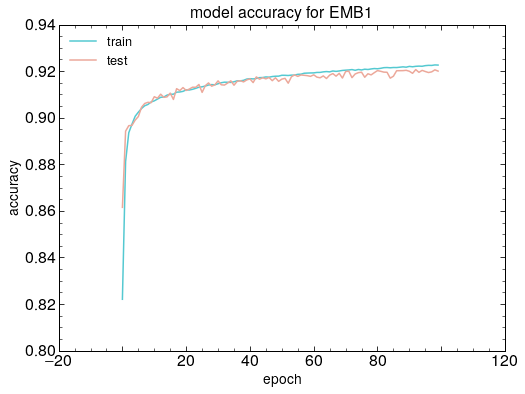

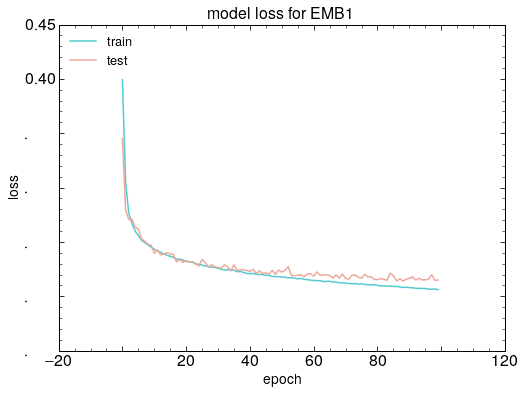

<Figure size 576x432 with 0 Axes>

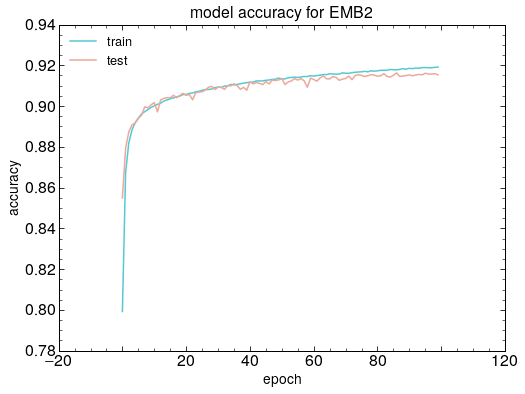

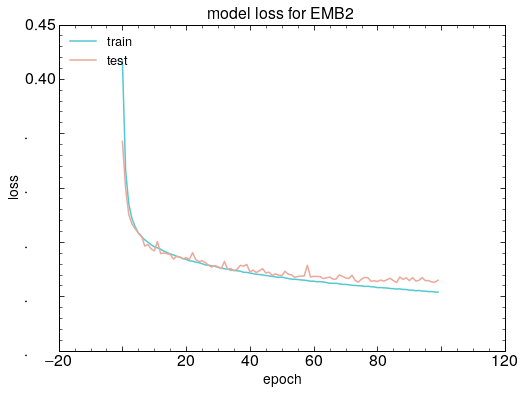

<Figure size 576x432 with 0 Axes>

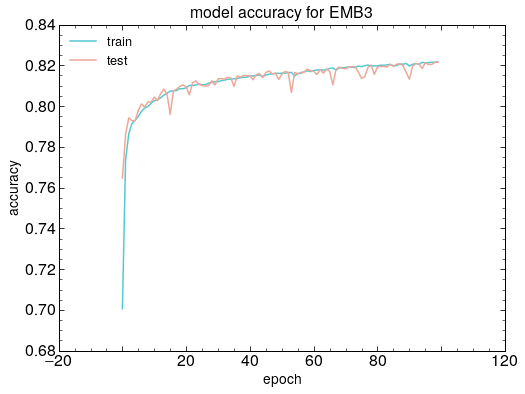

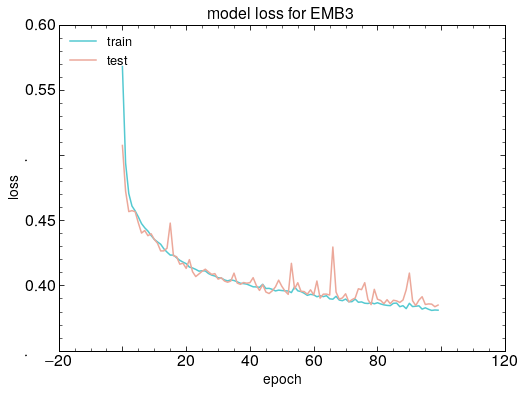

<Figure size 576x432 with 0 Axes>

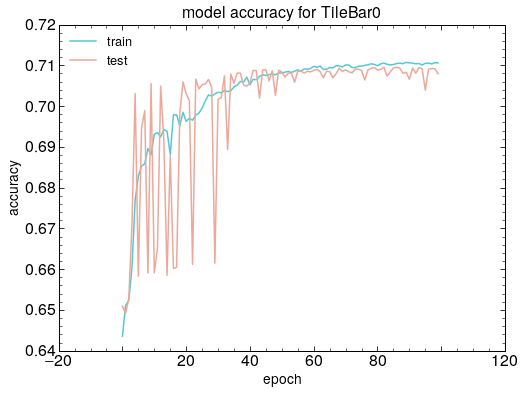

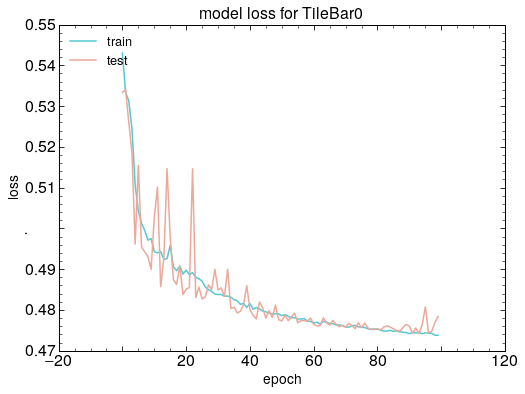

<Figure size 576x432 with 0 Axes>

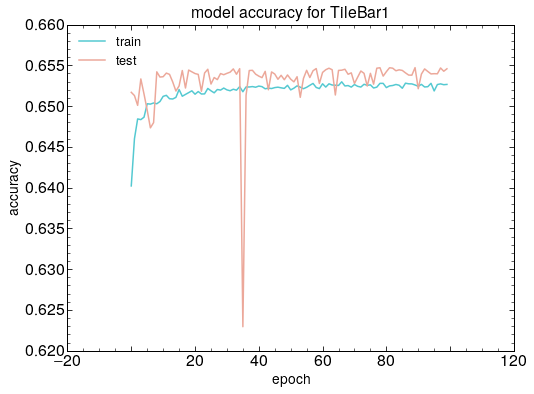

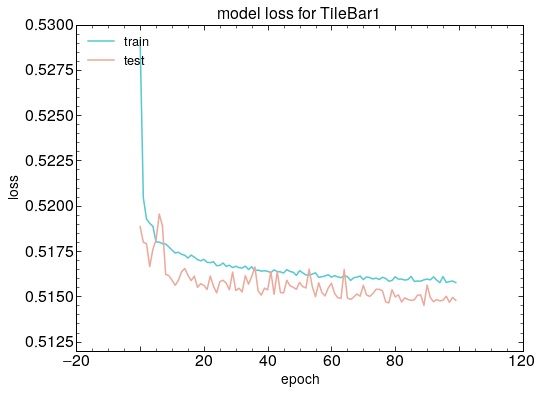

<Figure size 576x432 with 0 Axes>

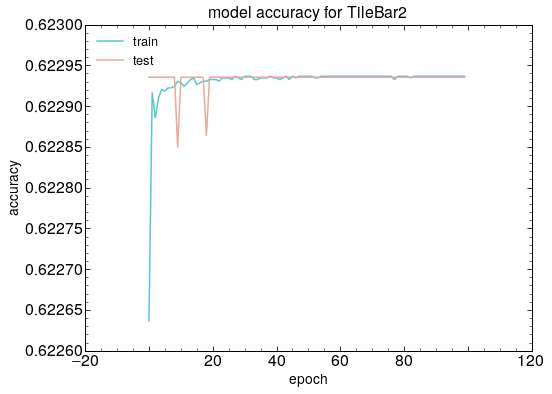

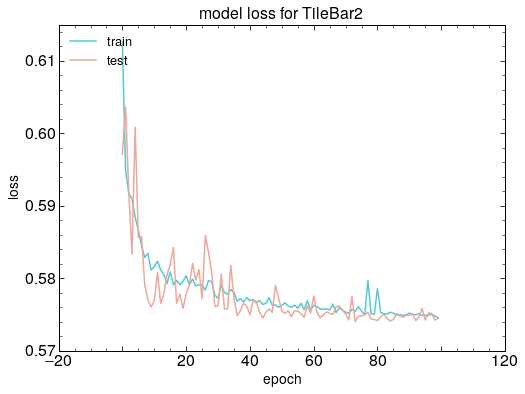

In [16]:
for layer in mu.cell_meta:
#     print(history_flat[layer_i].history.keys())
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history[layer].history['acc'])
    plt.plot(history[layer].history['val_acc'])
    plt.title('model accuracy for ' + layer)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history[layer].history['loss'])
    plt.plot(history[layer].history['val_loss'])
    plt.title('model loss for ' + layer)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

In [19]:
from sklearn.metrics import roc_curve, auc

roc_fpr = {}
roc_tpr = {}
roc_thresh = {}
roc_auc = {}

for layer in mu.cell_meta:
    roc_fpr[layer], roc_tpr[layer], roc_thresh[layer] = roc_curve(
        plabels[pdata_merged.test][:,1],
        scores[layer][pdata_merged.test,1],
        drop_intermediate=False,
    )
    roc_auc[layer] = auc(roc_fpr[layer], roc_tpr[layer])
    print('Area under curve for ' + layer + ': ' + str(roc_auc[layer]))

NameError: name 'scores' is not defined

<Figure size 576x432 with 0 Axes>

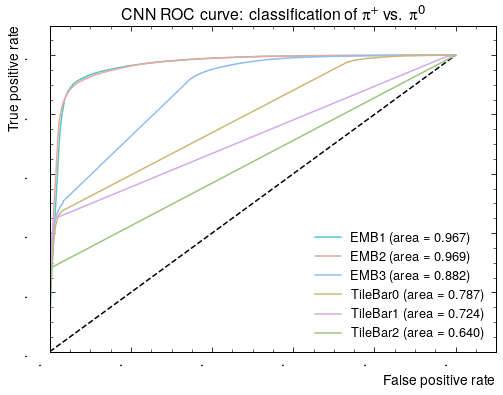

In [21]:
pu.roc_plot([roc_fpr[layer] for layer in mu.cell_meta],
            [roc_tpr[layer] for layer in mu.cell_meta],
            figfile=plotpath + 'roc_cnn_all.pdf',
            labels=['{} (area = {:.3f})'.format(layer, roc_auc[layer]) for layer in mu.cell_meta],
            extra_lines=[[[0, 1], [0, 1]]],
            title='CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')

<Figure size 576x432 with 0 Axes>

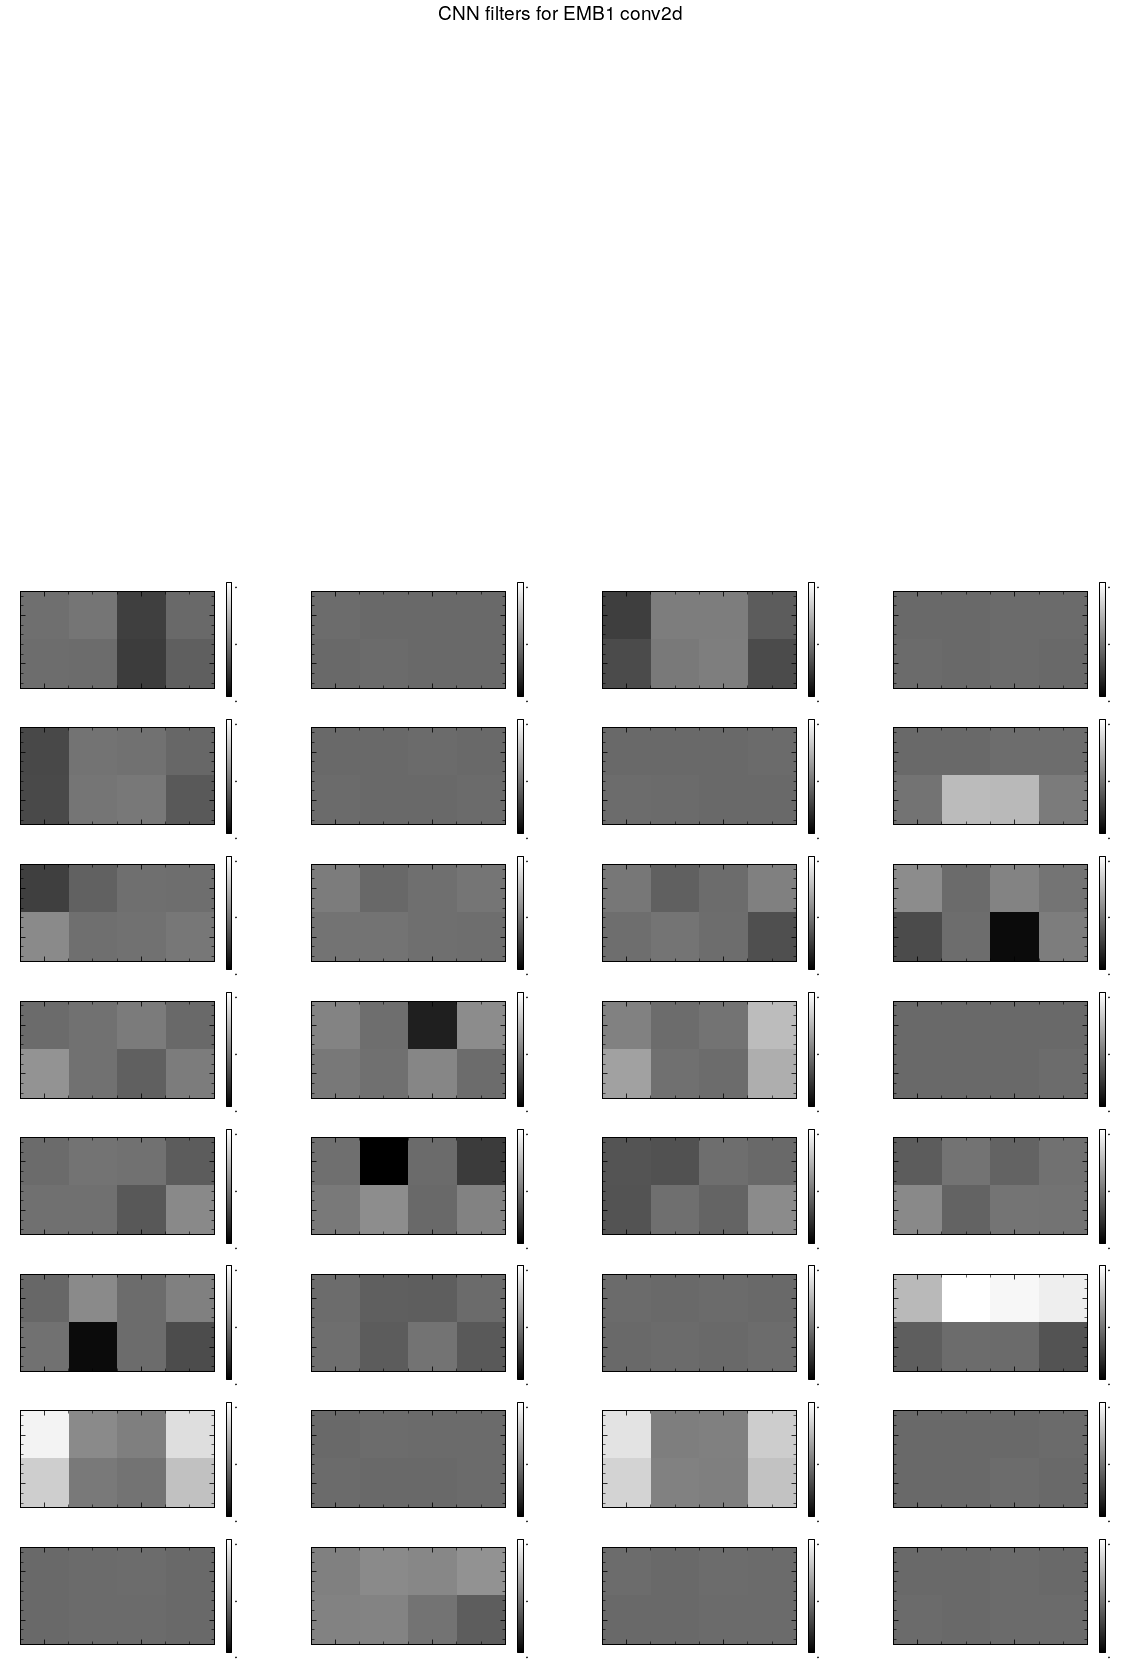

<Figure size 576x432 with 0 Axes>

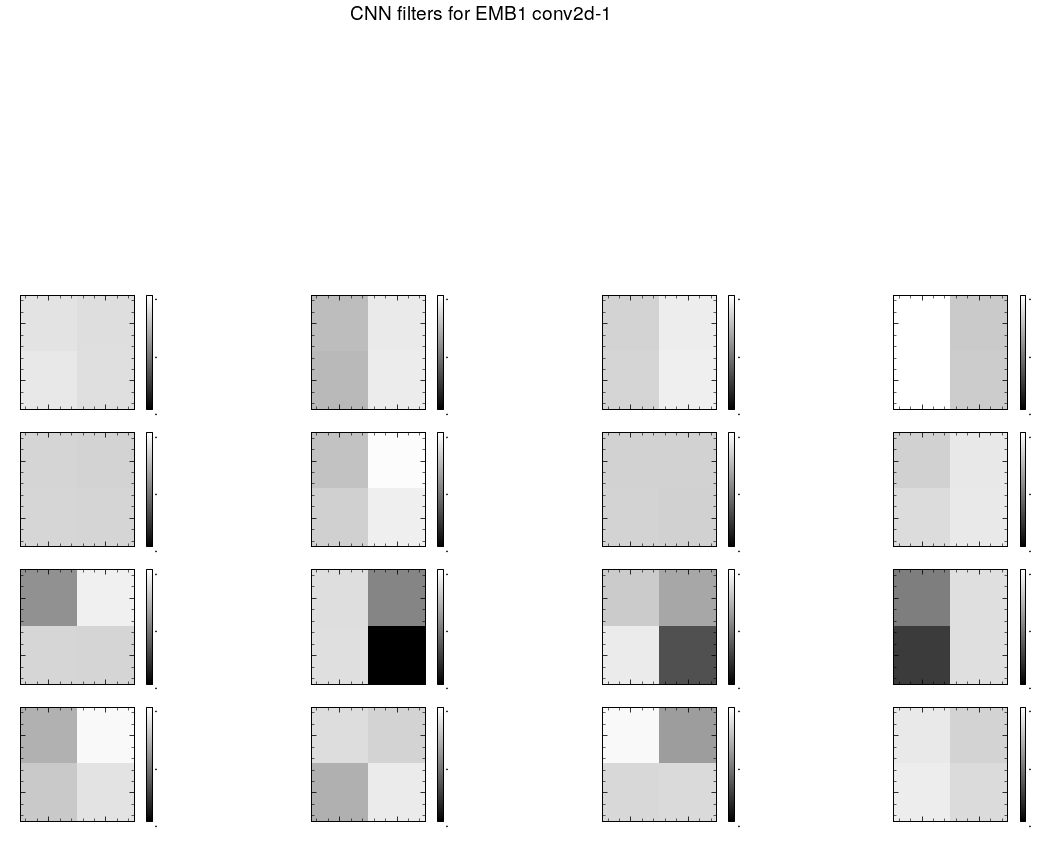

<Figure size 576x432 with 0 Axes>

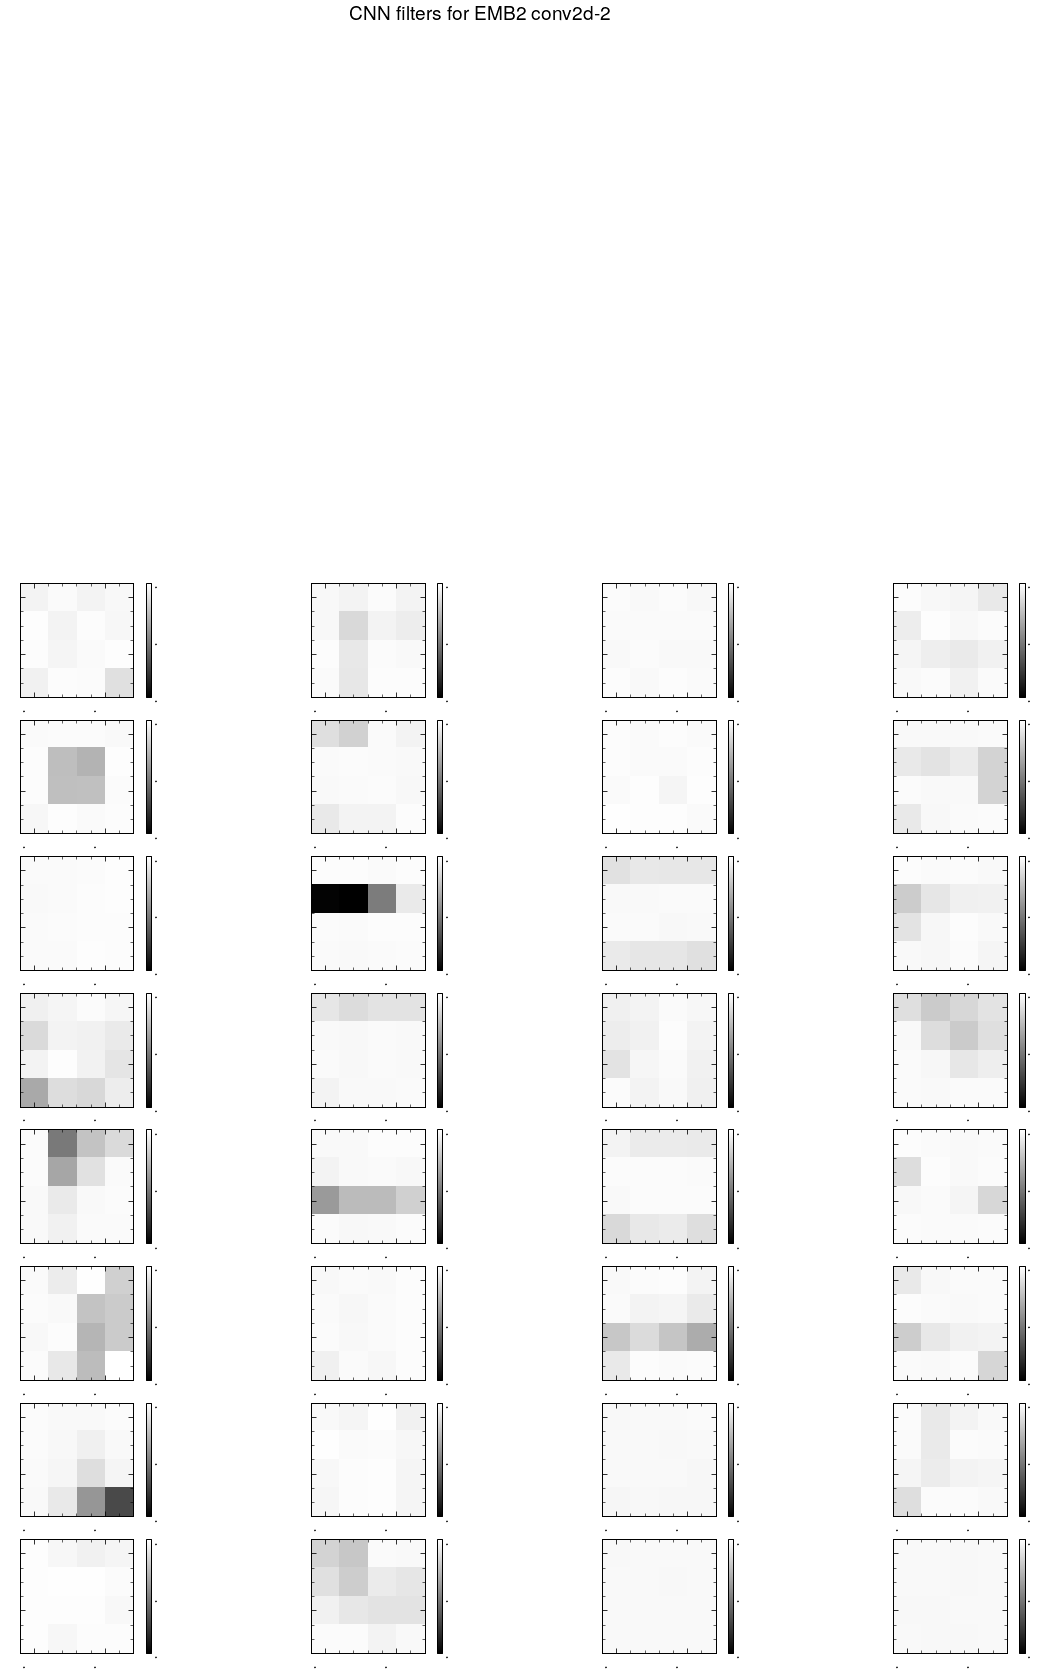

<Figure size 576x432 with 0 Axes>

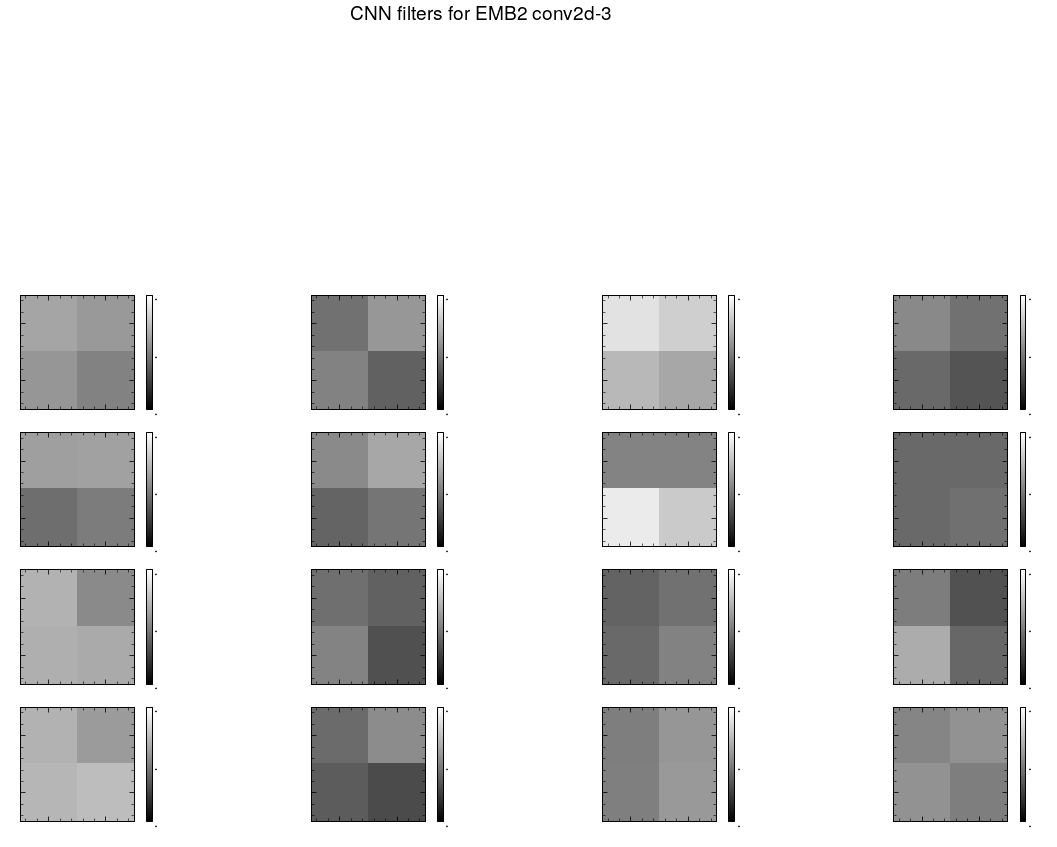

<Figure size 576x432 with 0 Axes>

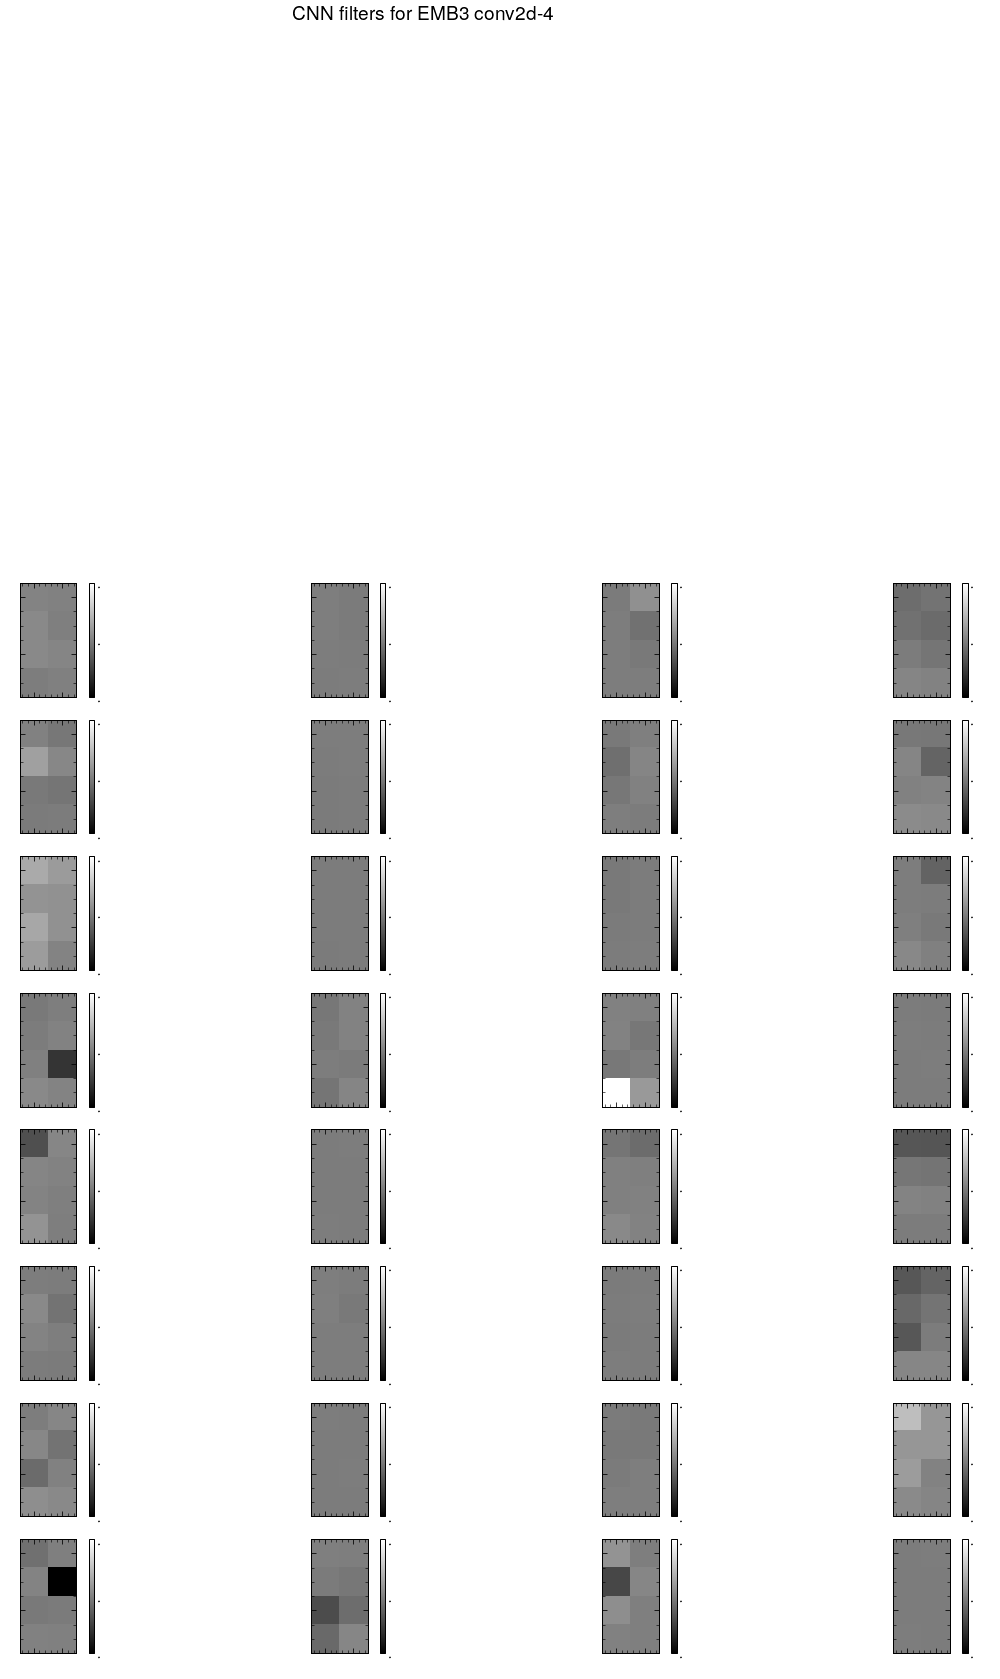

<Figure size 576x432 with 0 Axes>

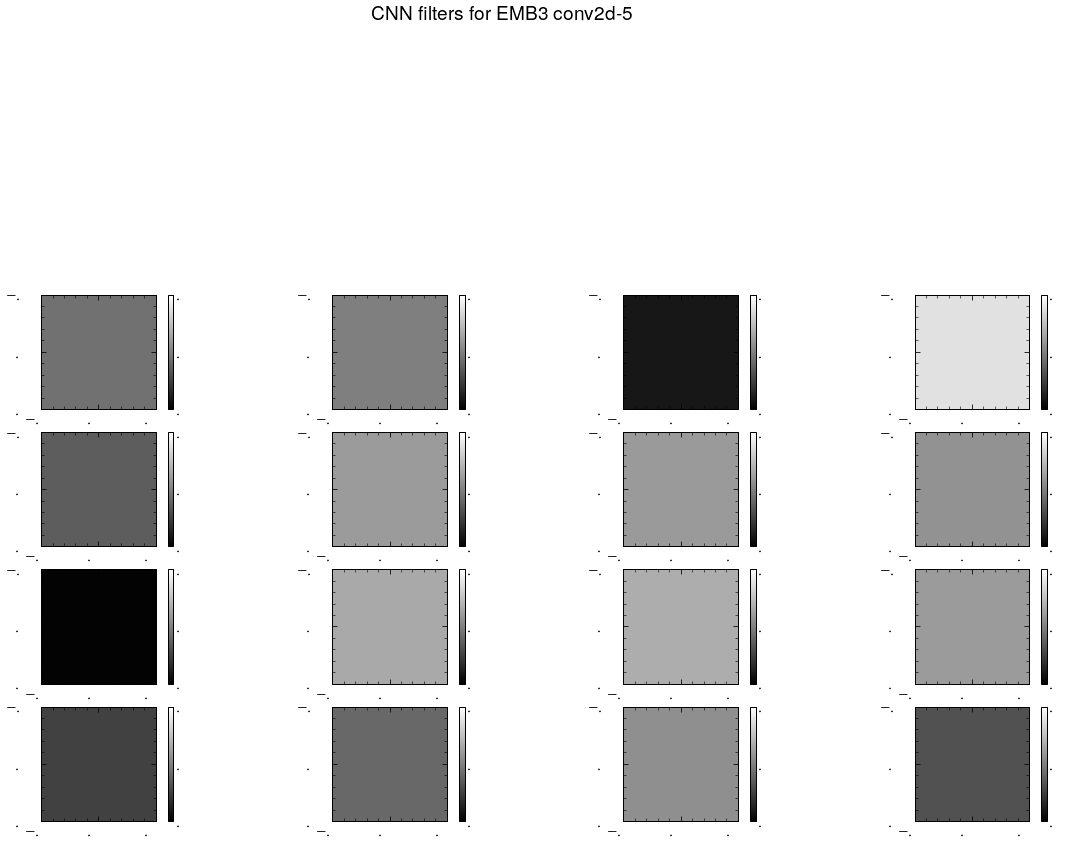

<Figure size 576x432 with 0 Axes>

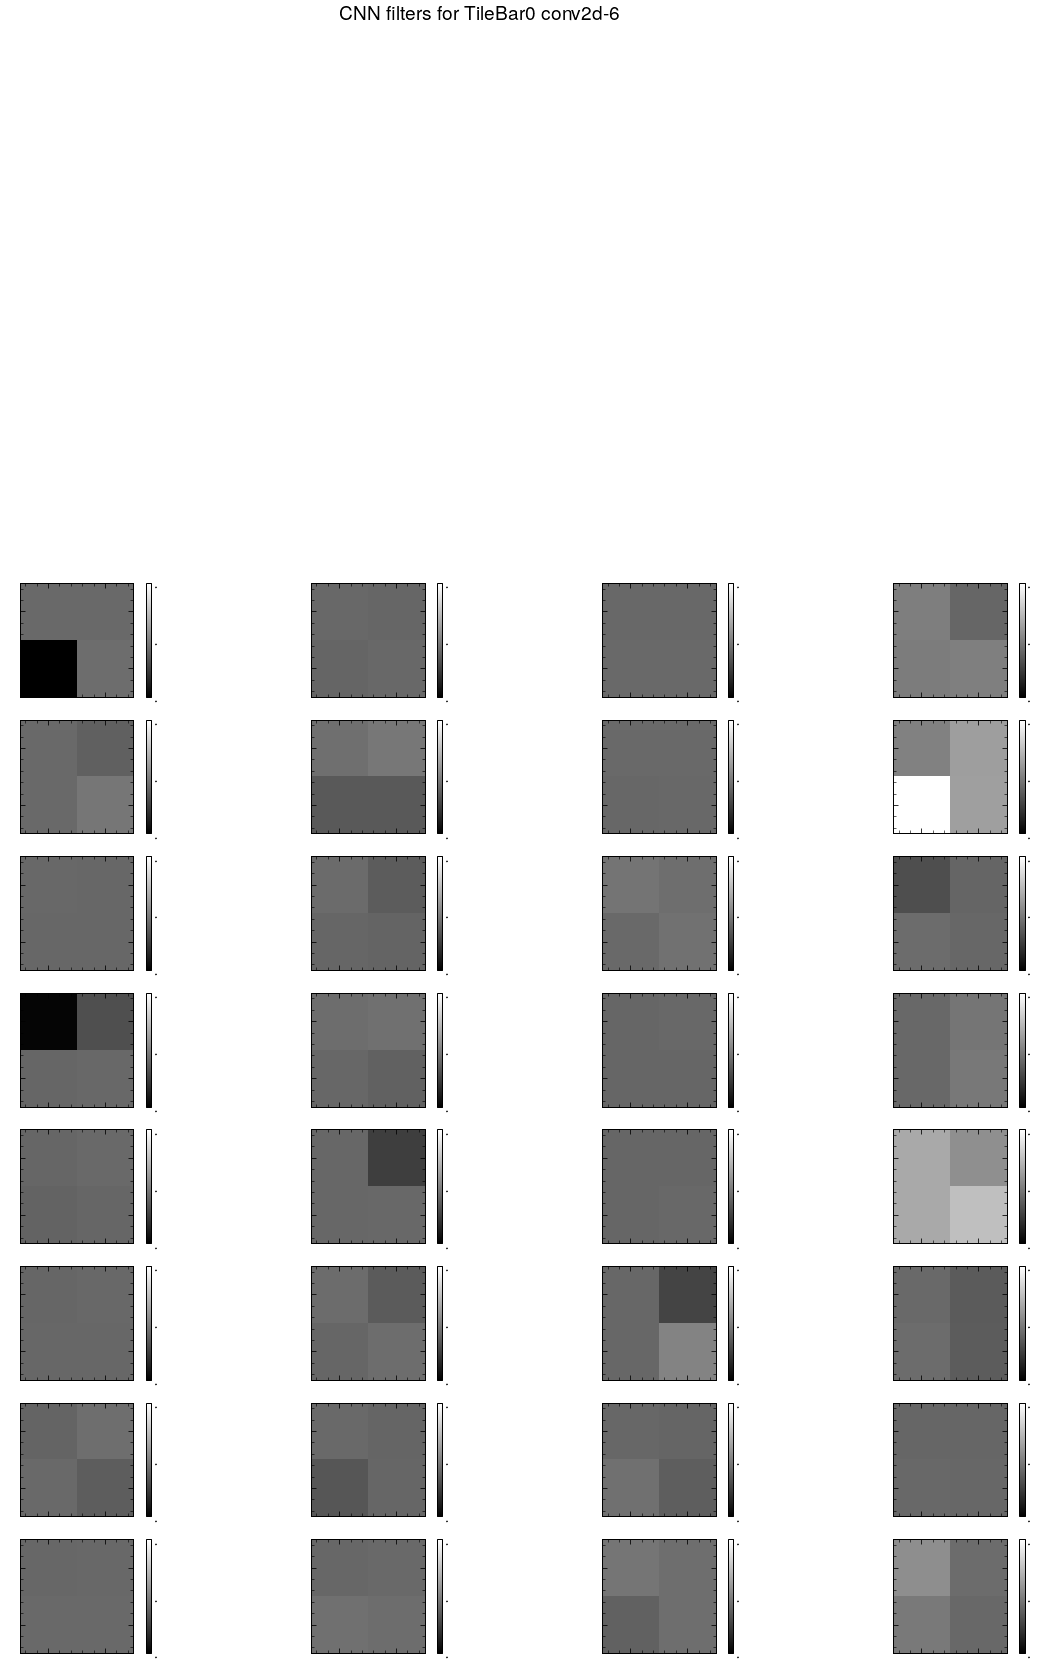

<Figure size 576x432 with 0 Axes>

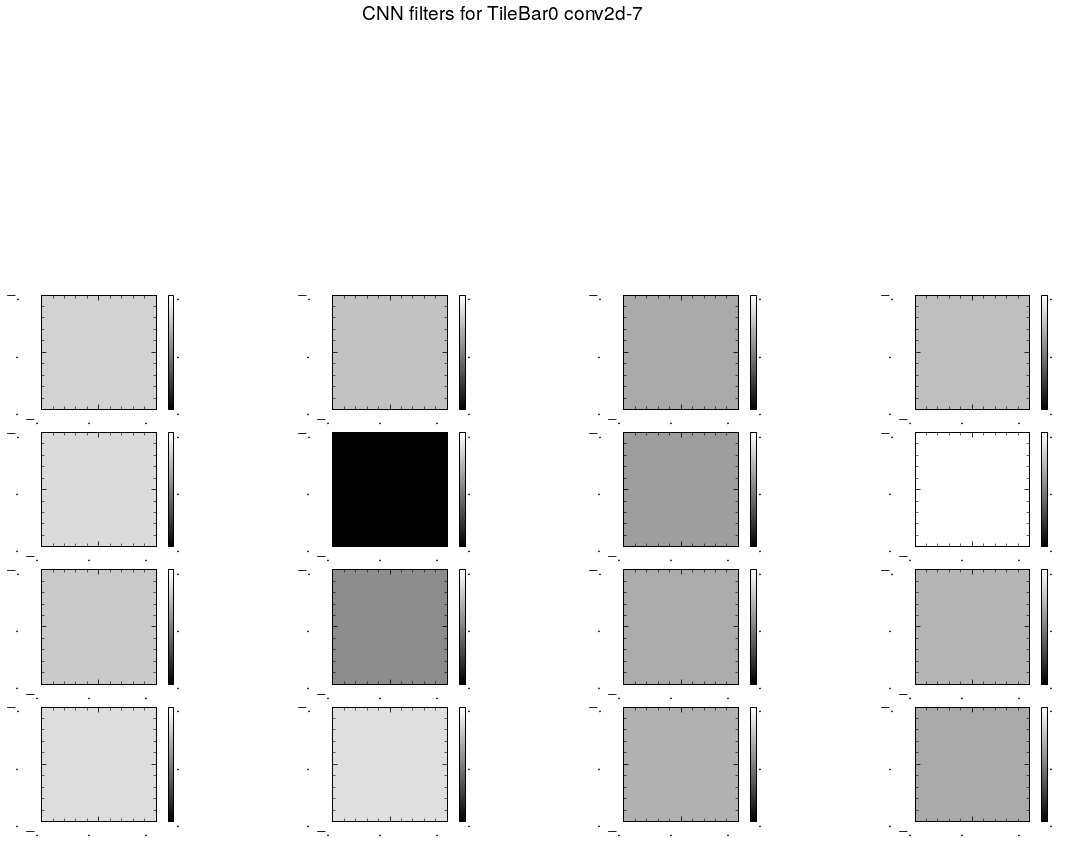

<Figure size 576x432 with 0 Axes>

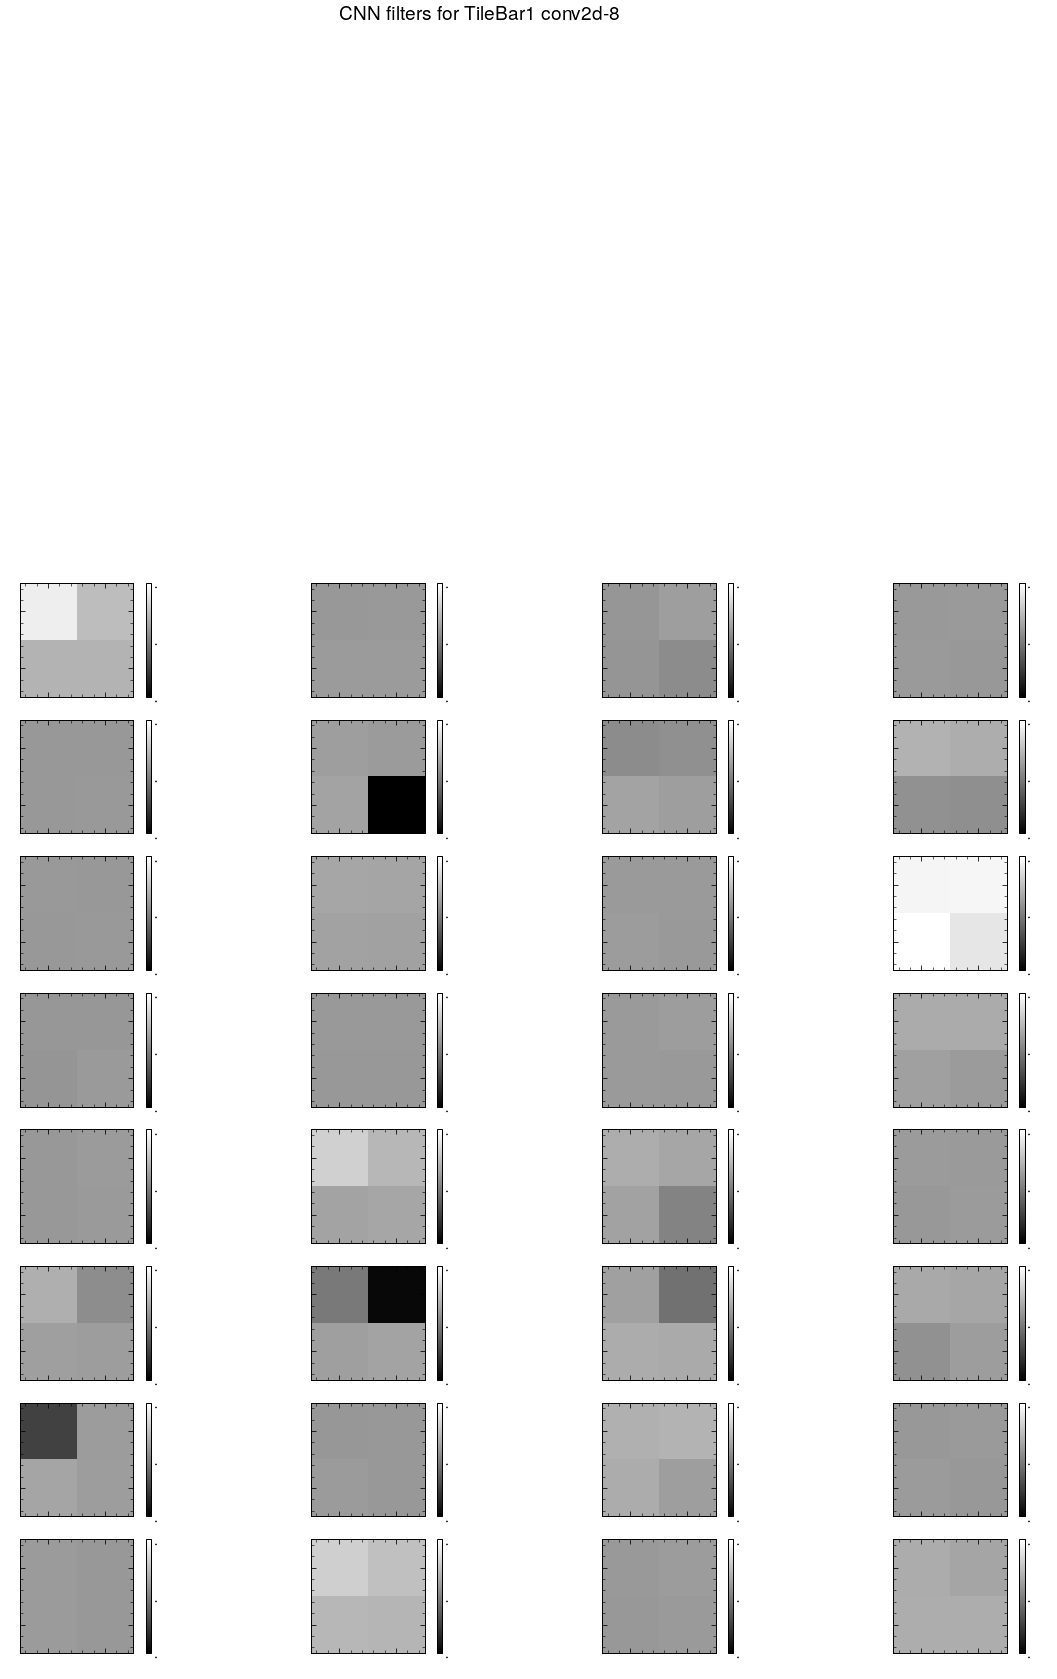

<Figure size 576x432 with 0 Axes>

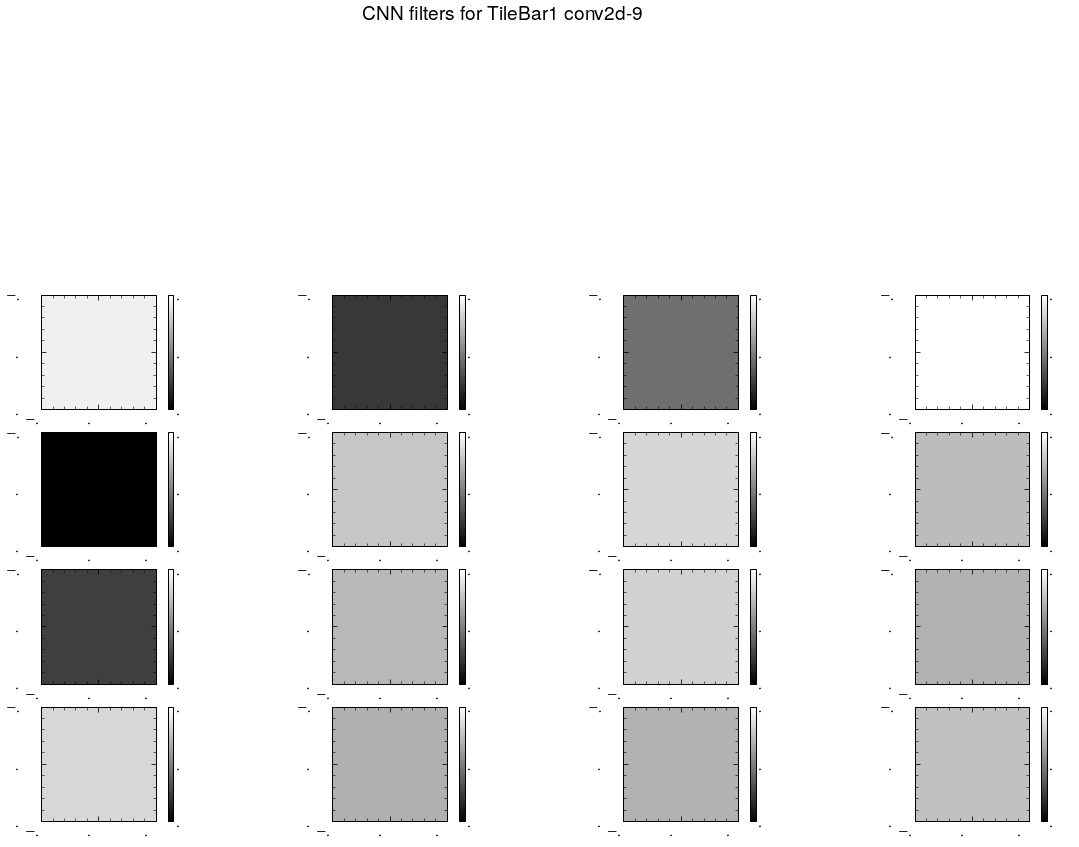

<Figure size 576x432 with 0 Axes>

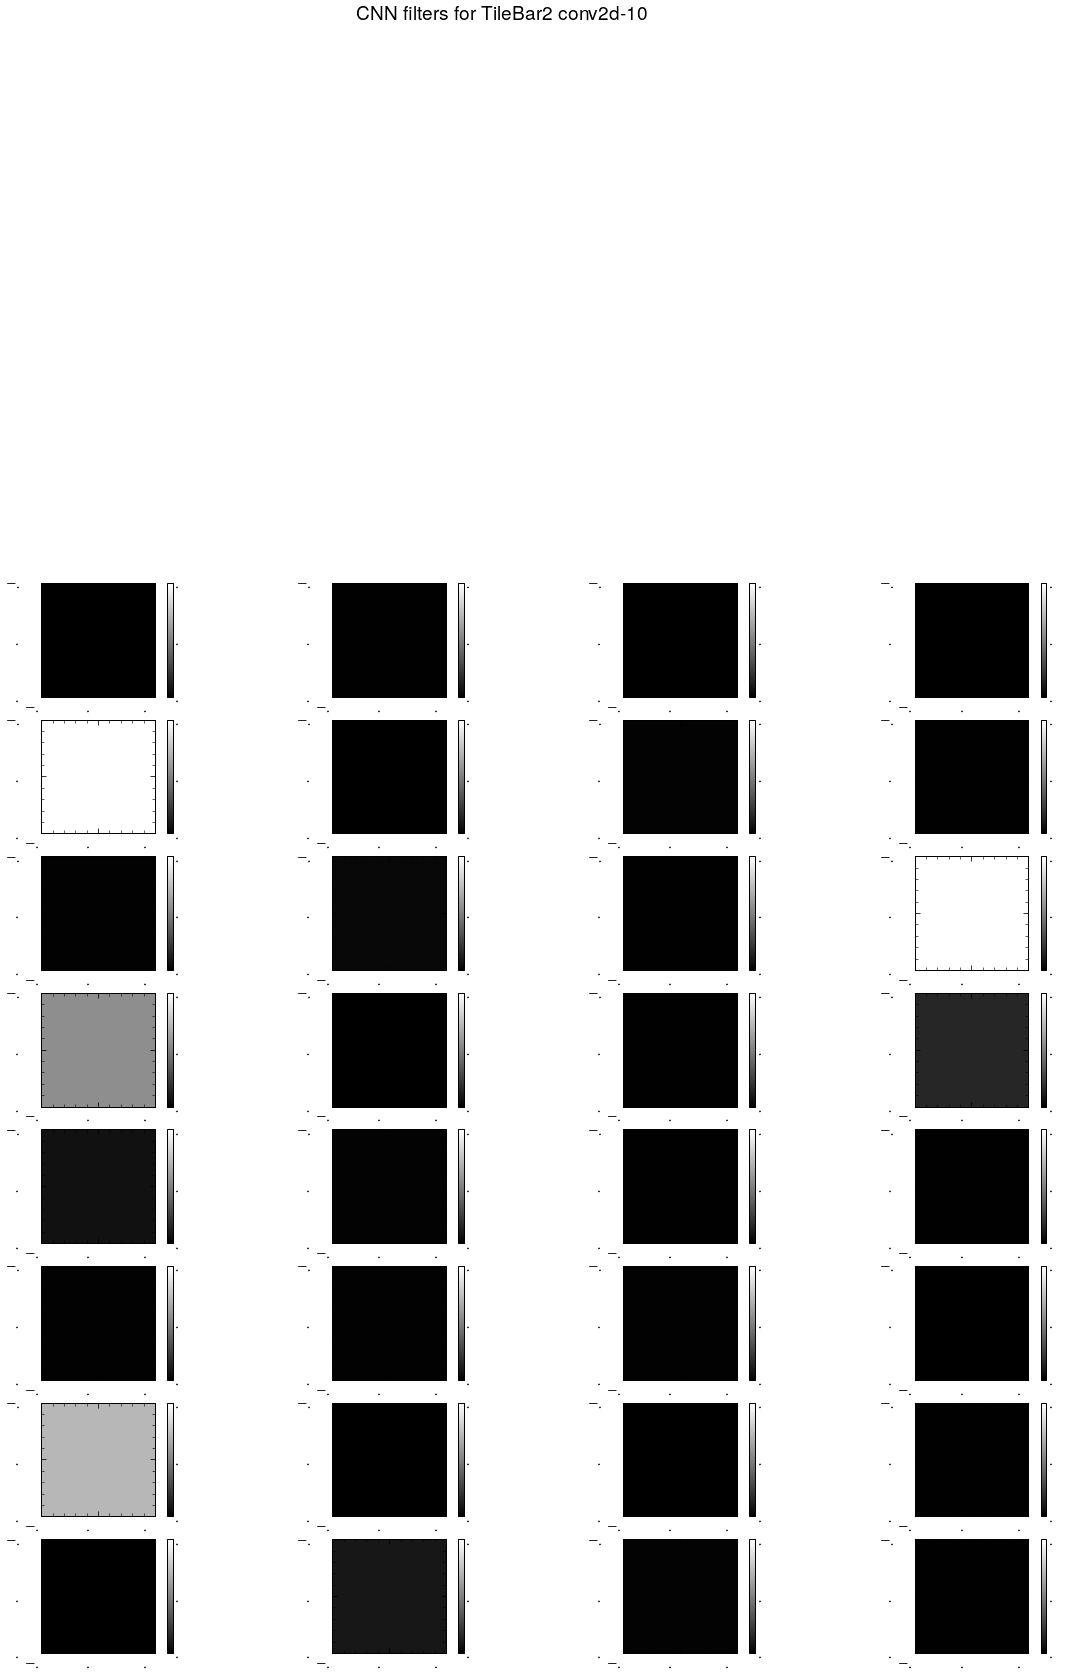

<Figure size 576x432 with 0 Axes>

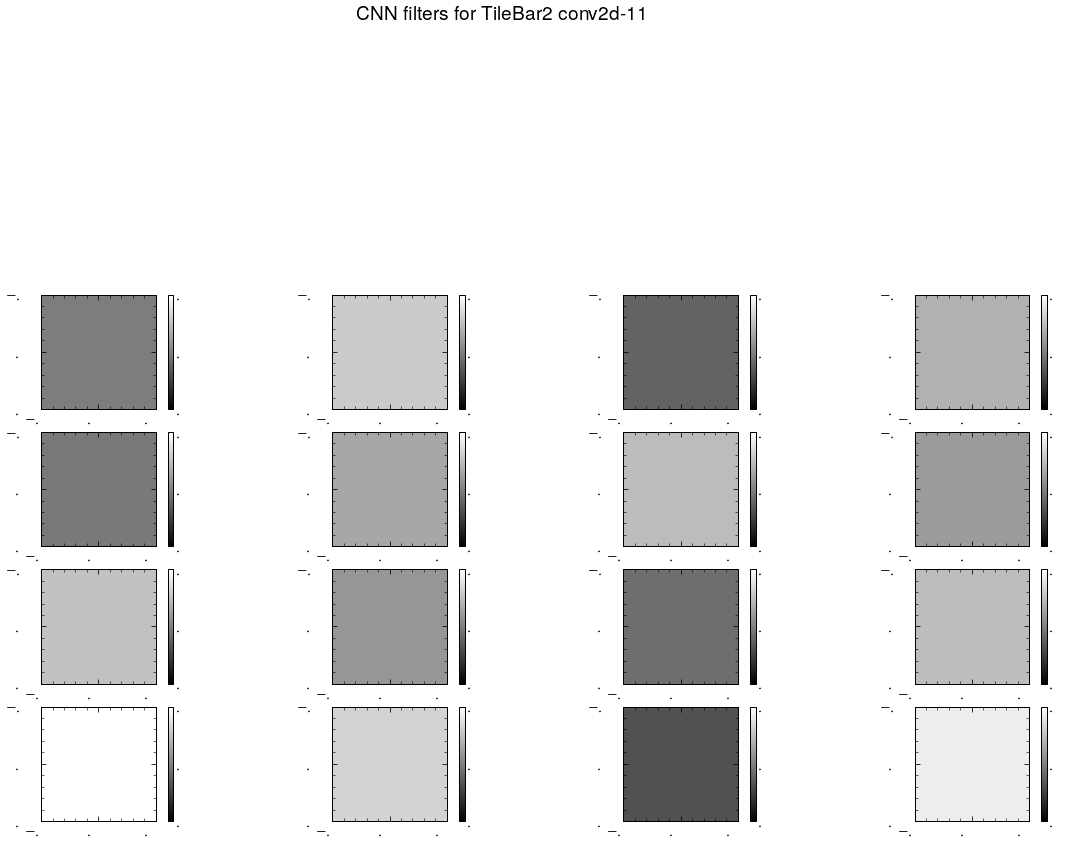

In [58]:
# Visualising CNN filters
fig_width = 4
ubound = 1
lbound = 0
zscale = np.linspace(lbound, ubound, 5, endpoint=True)

for layer, model in models.items():
    for mlayer in model.layers:
        # filter for only convolutional layers
        if 'conv' not in mlayer.name:
            continue

        filters, biases = mlayer.get_weights()
#         print(layer, mlayer.name, filters.shape)
        
        # normalise filter weights to the range [0,1]
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)
        
        # render filters as greyscale plots
        plt.cla(); plt.clf()
        fig = plt.figure(figsize=(fig_width*5,filters.shape[3]*10/fig_width))
        fig.patch.set_facecolor('white')
        plt.suptitle('CNN filters for '+layer+' '+mlayer.name.replace('_','-'))
        
        for i in range(filters.shape[3]):
            plt.subplot(filters.shape[3], fig_width, i+1)
            plt.imshow(filters[:,:,0,i], cmap='gray',
                      vmin=lbound, vmax=ubound)
            plt.colorbar()
        plt.savefig(plotpath+'cnn/cnnfilter_'+layer+'_'+mlayer.name+'.pdf')
        plt.show()
        

In [13]:
#find layer indices of convolutional layers
conv_layers = {}
for layer, model in models.items():
    conv_layers[layer] = []
    for i in range(len(model.layers)):
        mlayer = model.layers[i]
        if 'conv' not in mlayer.name:
            continue
        print(layer, i, mlayer.name, mlayer.output.shape)
        conv_layers[layer].append(i)

EMB1 0 conv2d (None, 32, 127, 1)
EMB1 2 conv2d_1 (None, 15, 62, 16)
EMB2 0 conv2d_2 (None, 32, 13, 13)
EMB2 2 conv2d_3 (None, 15, 5, 16)
EMB3 0 conv2d_4 (None, 32, 5, 15)
EMB3 2 conv2d_5 (None, 16, 2, 16)
TileBar0 0 conv2d_6 (None, 32, 3, 3)
TileBar0 2 conv2d_7 (None, 16, 1, 16)
TileBar1 0 conv2d_8 (None, 32, 3, 3)
TileBar1 2 conv2d_9 (None, 16, 1, 16)
TileBar2 0 conv2d_10 (None, 32, 2, 4)
TileBar2 2 conv2d_11 (None, 16, 1, 16)


In [23]:
models['EMB1'].predict(pcells_merged_reshaped['EMB1'])

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Conv2D (defined at <ipython-input-16-47fe8743ecff>:1) ]] [Op:__inference_distributed_function_5560]

Function call stack:
distributed_function


In [15]:
featuremaps = {}
for layer, model in models.items():
    average_event = pcells_merged_reshaped[layer][pdata_merged.test].sum(axis=0)
    average_event = np.expand_dims(average_event,axis=0)
    featuremaps[layer] = []
    for conv_layer_index in conv_layers[layer]:
        print(layer, conv_layer_index)
        featuremap_model = Model(inputs=model.inputs, outputs=model.layers[conv_layer_index].output)
        featuremaps[layer].append(featuremap_model.predict(average_event))
        

EMB1 0


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model_1/conv2d/Conv2D (defined at <ipython-input-15-69db781c9aee>:9) ]] [Op:__inference_distributed_function_5461]

Function call stack:
distributed_function


## More with CNN's

In [11]:
def merged_model_emb123():
    with strategy.scope():
        # EMB1 image (flat, fully-connected)
        input1 = Input(shape=(1, 128, 4), name='input1')
        x1 = Convolution2D(32, (4, 2), activation='relu', data_format = 'channels_first')(input1)
        x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)

        # EMB2 image (convolutional)
        input2 = Input(shape=(1,16,16), name='input2')
        x2 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input2)
        x2 = MaxPool2D(pool_size=(2, 2))(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Flatten()(x2)
        x2 = Dense(128, activation='relu')(x2)
    
        # EMB3 image (convolutional)
        input3 = Input(shape=(1,8,16), name='input3')
        x3 = Convolution2D(32, (2, 4), activation='relu', data_format = 'channels_first')(input3)
        x3 = MaxPool2D(pool_size=(1, 2))(x3)
        x3 = Dropout(0.2)(x3)
        x3 = Flatten()(x3)
        x3 = Dense(128, activation='relu')(x3)

        # concatenate outputs from the three networks above
        x = concatenate([x1, x2, x3]) 
        x = Dense(50, activation='relu')(x)    

        # final output
        output = Dense(2, activation='softmax')(x)

        model = Model(inputs = [input1, input2, input3], outputs = [output])
    
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
        return model

In [12]:
merged_emb123 = merged_model_emb123()


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [17]:
tf.keras.utils.plot_model(merged_emb123, plotpath+'emb123_with_shape_info.png', show_shapes=True)


Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [18]:
history_emb123 = merged_emb123.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                                        pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                                        pcells_merged_reshaped['EMB3'][pdata_merged.val]], 
                                                        plabels[pdata_merged.val]),                            
                                    epochs=250, batch_size=200*ngpu, verbose=2)

cy: 0.9437
Epoch 69/250
489899/489899 - 13s - loss: 0.1585 - accuracy: 0.9428 - val_loss: 0.1602 - val_accuracy: 0.9433
Epoch 70/250
489899/489899 - 13s - loss: 0.1584 - accuracy: 0.9429 - val_loss: 0.1586 - val_accuracy: 0.9443
Epoch 71/250
489899/489899 - 13s - loss: 0.1587 - accuracy: 0.9426 - val_loss: 0.1611 - val_accuracy: 0.9437
Epoch 72/250
489899/489899 - 13s - loss: 0.1579 - accuracy: 0.9428 - val_loss: 0.1595 - val_accuracy: 0.9432
Epoch 73/250
489899/489899 - 13s - loss: 0.1577 - accuracy: 0.9431 - val_loss: 0.1583 - val_accuracy: 0.9444
Epoch 74/250
489899/489899 - 13s - loss: 0.1576 - accuracy: 0.9431 - val_loss: 0.1574 - val_accuracy: 0.9448
Epoch 75/250
489899/489899 - 13s - loss: 0.1575 - accuracy: 0.9435 - val_loss: 0.1598 - val_accuracy: 0.9440
Epoch 76/250
489899/489899 - 13s - loss: 0.1576 - accuracy: 0.9429 - val_loss: 0.1601 - val_accuracy: 0.9439
Epoch 77/250
489899/489899 - 13s - loss: 0.1567 - accuracy: 0.9436 - val_loss: 0.1596 - val_accuracy: 0.9430
Epoch 78

In [19]:
merged_emb123.save(modelpath+'model_emb123.h5')

<Figure size 576x432 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


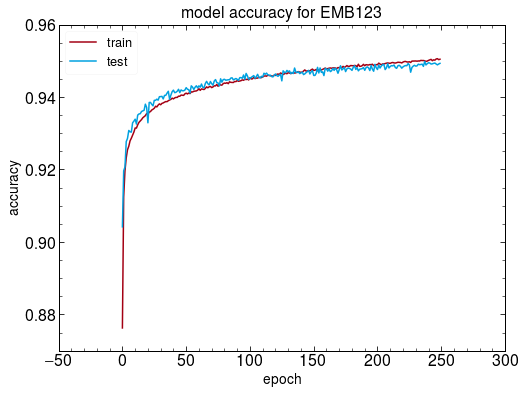

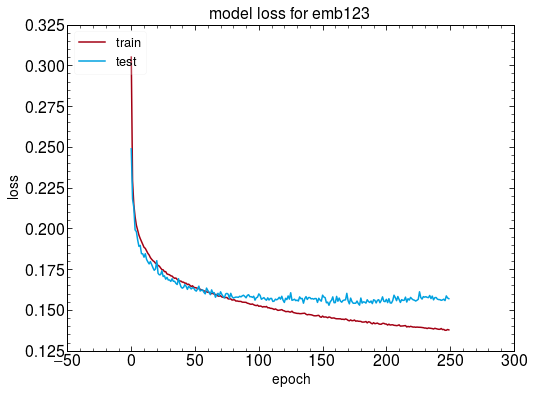

In [20]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_emb123.history['accuracy'])
    plt.plot(history_emb123.history['val_accuracy'])
    plt.title('model accuracy for EMB123')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_emb123.history['loss'])
    plt.plot(history_emb123.history['val_loss'])
    plt.title('model loss for emb123')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

In [21]:
scores_123 = merged_emb123.predict(
        [pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3']]
        )

In [22]:
from sklearn.metrics import roc_curve, auc
roc_fpr_123, roc_tpr_123, roc_thresh_123 = roc_curve(
        plabels[pdata_merged.test][:,1],
        scores_123[pdata_merged.test,1],
        drop_intermediate=False,
    )
roc_auc_123 = auc(roc_fpr_123, roc_tpr_123)
print('Area under curve for EMB123 ' + str(roc_auc_123))

Area under curve for EMB123 0.9851758110140667


<Figure size 576x432 with 0 Axes>

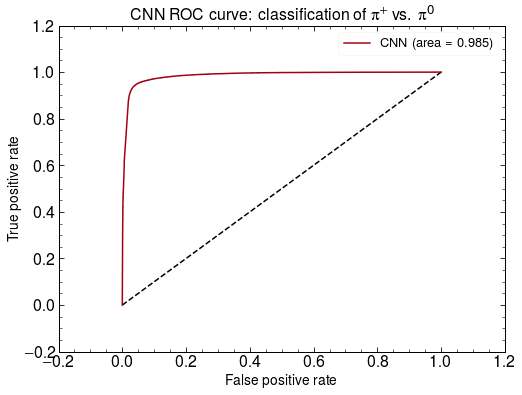

In [23]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_123, roc_tpr_123, label='CNN (area = {:.3f})'.format(roc_auc_123))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
# plt.savefig('Plots/roc_lc_only.pdf')
plt.show()

In [30]:
def merged_model_all():
    with strategy.scope():
        # EMB1 image (convolutional)
        input1 = Input(shape=(1, 128, 4), name='input1')
        x1 = Convolution2D(32, (4, 2), activation='relu', data_format = 'channels_first')(input1)
        x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)

        # EMB2 image (convolutional)
        input2 = Input(shape=(1,16,16), name='input2')
        x2 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input2)
        x2 = MaxPool2D(pool_size=(2, 2))(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Flatten()(x2)
        x2 = Dense(128, activation='relu')(x2)
    
        # EMB3 image (convolutional)
        input3 = Input(shape=(1,8,16), name='input3')
        x3 = Convolution2D(32, (2, 4), activation='relu', data_format = 'channels_first')(input3)
        x3 = MaxPool2D(pool_size=(2, 2))(x3)
        x3 = Dropout(0.2)(x3)
        x3 = Flatten()(x3)
        x3 = Dense(128, activation='relu')(x3)

        input4 = Input(shape=(1,4,4), name='input4')
        x4 = Convolution2D(32, (2,2), activation='relu', data_format = 'channels_first')(input4)
        x4 = MaxPool2D(pool_size=(2,2))(x4)
        x4 = Dropout(0.2)(x4)
        x4 = Flatten()(x4)
        x4 = Dense(128, activation='relu')(x4)

        input5 = Input(shape=(1,4,4), name='input5')
        x5 = Convolution2D(32, (2,2), activation='relu', data_format = 'channels_first')(input5)
        x5 = MaxPool2D(pool_size=(2,2))(x5)
        x5 = Dropout(0.2)(x5)
        x5 = Flatten()(x5)
        x5 = Dense(128, activation='relu')(x5)

        input6 = Input(shape=(1,2,4), name='input6')
        x6 = Convolution2D(32, (2,2), activation='relu', data_format = 'channels_first')(input6)
        x6 = MaxPool2D(pool_size=(2,1))(x6)
        x6 = Dropout(0.2)(x6)
        x6 = Flatten()(x6)
        x6 = Dense(128, activation='relu')(x6)

        # concatenate outputs from the three networks above
        x = concatenate([x1, x2, x3, x4, x5, x6]) 
        x = Dense(50, activation='relu')(x)    

        # final output
        output = Dense(2, activation='softmax')(x)

        model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])
    
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
        return model

In [31]:
merged_all = merged_model_all()
merged_all.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, 1, 128, 4)]  0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             [(None, 1, 16, 16)]  0                                            
__________________________________________________________________________________________________
input3 (InputLayer)             [(None, 1, 8, 16)]   0                                            
__________________________________________________________________________________________________
input4 (InputLayer)             [(None, 1, 4, 4)]    0                                            
____________________________________________________________________________________________

In [32]:
tf.keras.utils.plot_model(merged_all, plotpath+'all_with_shape_info.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [33]:
history_all = merged_all.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=250, batch_size=200*ngpu, verbose=2)
merged_all.save(modelpath+'model_cnn_all.h5')
scores_all = merged_all.predict(
        [pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']]
        )

cy: 0.9439
Epoch 69/250
489899/489899 - 17s - loss: 0.1551 - accuracy: 0.9436 - val_loss: 0.1557 - val_accuracy: 0.9437
Epoch 70/250
489899/489899 - 17s - loss: 0.1548 - accuracy: 0.9438 - val_loss: 0.1572 - val_accuracy: 0.9436
Epoch 71/250
489899/489899 - 17s - loss: 0.1550 - accuracy: 0.9435 - val_loss: 0.1573 - val_accuracy: 0.9432
Epoch 72/250
489899/489899 - 17s - loss: 0.1548 - accuracy: 0.9436 - val_loss: 0.1552 - val_accuracy: 0.9442
Epoch 73/250
489899/489899 - 17s - loss: 0.1545 - accuracy: 0.9437 - val_loss: 0.1548 - val_accuracy: 0.9449
Epoch 74/250
489899/489899 - 17s - loss: 0.1545 - accuracy: 0.9436 - val_loss: 0.1537 - val_accuracy: 0.9450
Epoch 75/250
489899/489899 - 17s - loss: 0.1537 - accuracy: 0.9437 - val_loss: 0.1555 - val_accuracy: 0.9436
Epoch 76/250
489899/489899 - 17s - loss: 0.1533 - accuracy: 0.9438 - val_loss: 0.1529 - val_accuracy: 0.9450
Epoch 77/250
489899/489899 - 17s - loss: 0.1532 - accuracy: 0.9441 - val_loss: 0.1551 - val_accuracy: 0.9447
Epoch 78

In [35]:
from sklearn.metrics import roc_curve, auc
roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(
        plabels[pdata_merged.test][:,1],
        scores_all[pdata_merged.test,1],
        drop_intermediate=False,
    )
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

Area under curve for CNN All 0.9863122921732519


<Figure size 576x432 with 0 Axes>

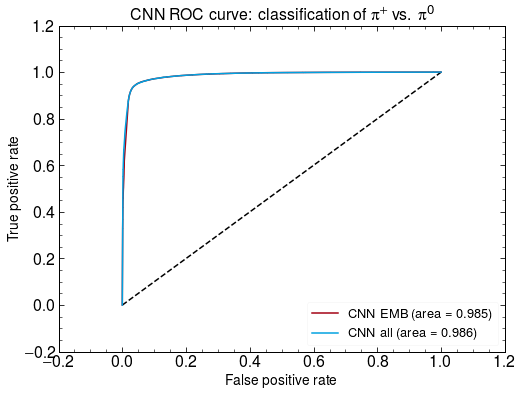

In [36]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_123, roc_tpr_123, label='CNN EMB (area = {:.3f})'.format(roc_auc_123))
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
# plt.savefig('Plots/roc_lc_only.pdf')
plt.show()

## Ok, now we play with more complicated models...

In [38]:
import scipy.ndimage

In [39]:
iterEMB2 = (zoom(cluster) for cluster in pcells_merged['EMB2'])

In [41]:
next(iterEMB2)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.

In [47]:
upscaledEMB3 = scipy.ndimage.zoom(pcells_merged['EMB3'], (1,2,1))

In [48]:
upscaledEMB3.shape

(699858, 16, 16)

In [50]:
downScaledEMB1 = scipy.ndimage.zoom(pcells_merged['EMB1'], (1,0.125,4))

In [53]:
downScaledEMB1.shape

(699858, 16, 16)

In [55]:
test = (1,2)

In [12]:
pcells_EMB2G_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (16, 16)))

In [22]:
pcells_EMB2G_channels.shape

(699858, 6, 16, 16)

In [32]:
def channels_EMB2G_model_all():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x1 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input1)
        x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)


        # final output
        output = Dense(2, activation='softmax')(x1)

        model = Model(inputs = [input1], outputs = [output])
    
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
        return model

In [33]:
model_channels = channels_EMB2G_model_all()
model_channels.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, 6, 16, 16)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 13, 13)        3104      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 6, 13)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 6, 13)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1248)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               159872    
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 258 

In [34]:
history_channels = model_channels.fit([pcells_EMB2G_channels[pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_EMB2G_channels[pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=250, batch_size=200*ngpu, verbose=2)

899 - 8s - loss: 0.1816 - accuracy: 0.9293 - val_loss: 0.1806 - val_accuracy: 0.9305
Epoch 68/250
489899/489899 - 9s - loss: 0.1816 - accuracy: 0.9292 - val_loss: 0.1797 - val_accuracy: 0.9301
Epoch 69/250
489899/489899 - 9s - loss: 0.1812 - accuracy: 0.9297 - val_loss: 0.1789 - val_accuracy: 0.9315
Epoch 70/250
489899/489899 - 9s - loss: 0.1814 - accuracy: 0.9295 - val_loss: 0.1777 - val_accuracy: 0.9313
Epoch 71/250
489899/489899 - 9s - loss: 0.1810 - accuracy: 0.9296 - val_loss: 0.1787 - val_accuracy: 0.9309
Epoch 72/250
489899/489899 - 9s - loss: 0.1812 - accuracy: 0.9296 - val_loss: 0.1788 - val_accuracy: 0.9306
Epoch 73/250
489899/489899 - 9s - loss: 0.1809 - accuracy: 0.9295 - val_loss: 0.1797 - val_accuracy: 0.9306
Epoch 74/250
489899/489899 - 9s - loss: 0.1808 - accuracy: 0.9296 - val_loss: 0.1790 - val_accuracy: 0.9299
Epoch 75/250
489899/489899 - 9s - loss: 0.1804 - accuracy: 0.9297 - val_loss: 0.1805 - val_accuracy: 0.9306
Epoch 76/250
489899/489899 - 9s - loss: 0.1805 - ac

In [35]:
print('test')

test


In [36]:
model_channels.save(modelpath+'model_cnn_channels.h5')


In [37]:
scores_chan = model_channels.predict(
        [pcells_EMB2G_channels]
        )

In [38]:
from sklearn.metrics import roc_curve, auc
roc_fpr_chan, roc_tpr_chan, roc_thresh_chan = roc_curve(
        plabels[pdata_merged.test][:,1],
        scores_chan[pdata_merged.test,1],
        drop_intermediate=False,
    )
roc_auc_chan = auc(roc_fpr_chan, roc_tpr_chan)
print('Area under curve for CNN All ' + str(roc_auc_chan))

Area under curve for CNN All 0.9813898000348492


0.981 for no drop-out, but lots of overfitting

<Figure size 576x432 with 0 Axes>

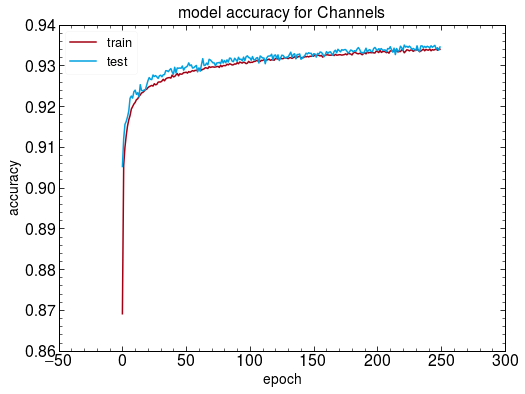

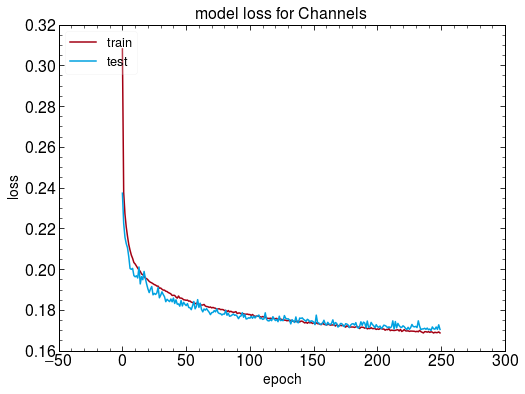

In [39]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_channels.history['accuracy'])
    plt.plot(history_channels.history['val_accuracy'])
    plt.title('model accuracy for Channels')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_channels.history['loss'])
    plt.plot(history_channels.history['val_loss'])
    plt.title('model loss for Channels')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

### Let's test the largest granularity possible

In [11]:
pcells_GG_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (128, 16)))

In [ ]:
def channels_GG_model_all():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 128, 16), name='input1')
        x1 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input1)
        x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)


        # final output
        output = Dense(2, activation='softmax')(x1)

        model = Model(inputs = [input1], outputs = [output])
    
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
        return model

### Ok that doesn't work because it's too big :D or at least I'm not patient enough

Instead let's try something simpler...

In [10]:
pcells_EMB2_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (16, 16)))

In [11]:
pcells_merged['EMB1'].shape

(699858, 128, 4)

In [12]:
pcells_EMB1_flat = pcells_merged['EMB1'].reshape(len(pcells_merged['EMB1']), 128 * 4)

In [22]:
def channels_EMB2G_EMB1F_model_all():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x1 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input1)
        x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)

        emb1_dim = 128*4
        #Here's EMB1 flattened
        input2 = Input(shape=(emb1_dim), name='input2')
        x2 = Dense(emb1_dim, activation='relu')(input2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 2, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 4, activation='relu')(x2)

        # concatenate outputs from the two networks above
        x = concatenate([x1, x2]) 
        x = Dense(50, activation='relu')(x)    

        # final output
        output = Dense(2, activation='softmax')(x)

        model = Model(inputs = [input1,input2], outputs = [output])
    
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
        return model

In [23]:
model_EMB2G_EMB1F = channels_EMB2G_EMB1F_model_all()
model_EMB2G_EMB1F.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, 6, 16, 16)]  0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             [(None, 512)]        0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 13, 13)   3104        input1[0][0]                     
__________

In [24]:
history_EMB2G_EMB1F = model_EMB2G_EMB1F.fit([pcells_EMB2_channels[pdata_merged.train], pcells_EMB1_flat[pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_EMB2_channels[pdata_merged.val], pcells_EMB1_flat[pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=250, batch_size=200*ngpu, verbose=2)
model_EMB2G_EMB1F.save(modelpath+'model_EMB2G_EMB1F.h5')
scores_EMB2G_EMB1F = model_EMB2G_EMB1F.predict([pcells_EMB2_channels, pcells_EMB1_flat])

cy: 0.9451
Epoch 69/250
489899/489899 - 12s - loss: 0.1508 - accuracy: 0.9452 - val_loss: 0.1540 - val_accuracy: 0.9450
Epoch 70/250
489899/489899 - 12s - loss: 0.1509 - accuracy: 0.9449 - val_loss: 0.1533 - val_accuracy: 0.9453
Epoch 71/250
489899/489899 - 12s - loss: 0.1506 - accuracy: 0.9449 - val_loss: 0.1543 - val_accuracy: 0.9452
Epoch 72/250
489899/489899 - 12s - loss: 0.1502 - accuracy: 0.9451 - val_loss: 0.1543 - val_accuracy: 0.9451
Epoch 73/250
489899/489899 - 12s - loss: 0.1499 - accuracy: 0.9455 - val_loss: 0.1533 - val_accuracy: 0.9455
Epoch 74/250
489899/489899 - 12s - loss: 0.1496 - accuracy: 0.9455 - val_loss: 0.1530 - val_accuracy: 0.9456
Epoch 75/250
489899/489899 - 12s - loss: 0.1495 - accuracy: 0.9453 - val_loss: 0.1555 - val_accuracy: 0.9452
Epoch 76/250
489899/489899 - 12s - loss: 0.1494 - accuracy: 0.9455 - val_loss: 0.1524 - val_accuracy: 0.9464
Epoch 77/250
489899/489899 - 12s - loss: 0.1496 - accuracy: 0.9456 - val_loss: 0.1536 - val_accuracy: 0.9457
Epoch 78

<Figure size 576x432 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


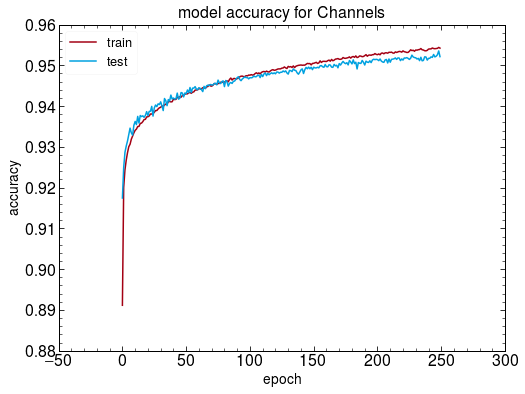

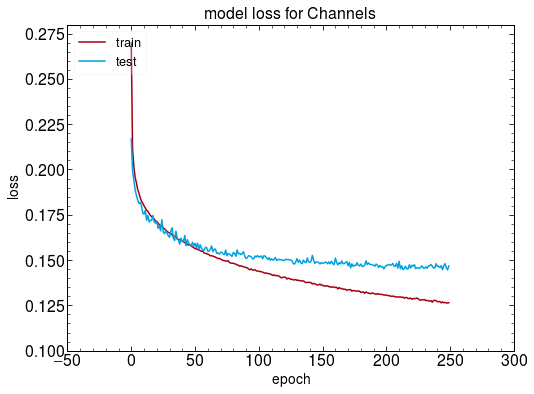

In [25]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_EMB2G_EMB1F.history['accuracy'])
    plt.plot(history_EMB2G_EMB1F.history['val_accuracy'])
    plt.title('model accuracy for Channels')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_EMB2G_EMB1F.history['loss'])
    plt.plot(history_EMB2G_EMB1F.history['val_loss'])
    plt.title('model loss for Channels')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

In [27]:
from sklearn.metrics import roc_curve, auc
roc_fpr_EMB2G_EMB1F, roc_tpr_EMB2G_EMB1F, roc_thresh_EMB2G_EMB1F = roc_curve(
        plabels[pdata_merged.test][:,1],
        scores_EMB2G_EMB1F[pdata_merged.test,1],
        drop_intermediate=False,
    )
roc_auc_EMB2G_EMB1F = auc(roc_fpr_EMB2G_EMB1F, roc_tpr_EMB2G_EMB1F)
print('Area under curve for CNN EMB2G_EMB1F ' + str(roc_auc_EMB2G_EMB1F))

Area under curve for CNN EMB2G_EMB1F 0.9869094274060531


<Figure size 576x432 with 0 Axes>

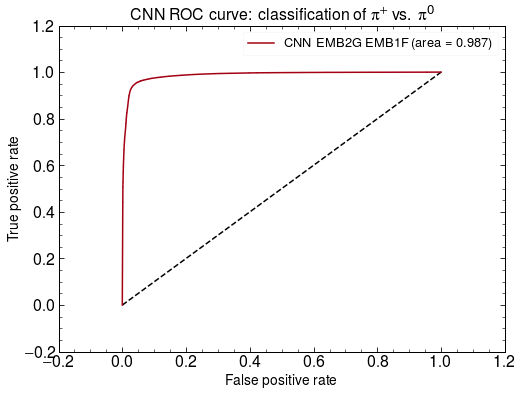

In [31]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_EMB2G_EMB1F, roc_tpr_EMB2G_EMB1F, label='CNN EMB2G EMB1F (area = {:.3f})'.format(roc_auc_EMB2G_EMB1F))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig(plotpath+'/roc_EMB2G_EMB1F_only.pdf')
plt.show()

In [10]:
def channels_EMB2G_EMB1F_model_all2():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x1 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input1)
        # x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Dense(64, activation='relu')(x1)

        emb1_dim = 128*4
        #Here's EMB1 flattened
        input2 = Input(shape=(emb1_dim), name='input2')
        x2 = Dense(emb1_dim, activation='relu')(input2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 2, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 4, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 8, activation='relu')(x2)

        # concatenate outputs from the two networks above
        x = concatenate([x1, x2]) 
        x = Dense(50, activation='relu')(x)    

        # final output
        output = Dense(2, activation='softmax')(x)

        model = Model(inputs = [input1,input2], outputs = [output])
    
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
        return model

In [16]:
model_EMB2G_EMB1F_2 = channels_EMB2G_EMB1F_model_all2()
model_EMB2G_EMB1F_2.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 512)          262656      input2[0][0]                     
__________________________________________________________________________________________________
input1 (InputLayer)             [(None, 6, 16, 16)]  0                                            
__________

In [17]:
history_EMB2G_EMB1F_2 = model_EMB2G_EMB1F_2.fit([pcells_EMB2_channels[pdata_merged.train], pcells_EMB1_flat[pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_EMB2_channels[pdata_merged.val], pcells_EMB1_flat[pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=250, batch_size=200*ngpu, verbose=2)
model_EMB2G_EMB1F_2.save(modelpath+'model_EMB2G_EMB1F_2.h5')
scores_EMB2G_EMB1F_2 = model_EMB2G_EMB1F_2.predict([pcells_EMB2_channels, pcells_EMB1_flat])

cy: 0.9467
Epoch 69/250
489899/489899 - 13s - loss: 0.1444 - accuracy: 0.9479 - val_loss: 0.1519 - val_accuracy: 0.9470
Epoch 70/250
489899/489899 - 13s - loss: 0.1444 - accuracy: 0.9478 - val_loss: 0.1520 - val_accuracy: 0.9465
Epoch 71/250
489899/489899 - 13s - loss: 0.1433 - accuracy: 0.9485 - val_loss: 0.1570 - val_accuracy: 0.9449
Epoch 72/250
489899/489899 - 13s - loss: 0.1435 - accuracy: 0.9481 - val_loss: 0.1513 - val_accuracy: 0.9473
Epoch 73/250
489899/489899 - 13s - loss: 0.1431 - accuracy: 0.9482 - val_loss: 0.1525 - val_accuracy: 0.9466
Epoch 74/250
489899/489899 - 13s - loss: 0.1425 - accuracy: 0.9484 - val_loss: 0.1534 - val_accuracy: 0.9462
Epoch 75/250
489899/489899 - 13s - loss: 0.1426 - accuracy: 0.9485 - val_loss: 0.1532 - val_accuracy: 0.9465
Epoch 76/250
489899/489899 - 13s - loss: 0.1421 - accuracy: 0.9489 - val_loss: 0.1505 - val_accuracy: 0.9480
Epoch 77/250
489899/489899 - 13s - loss: 0.1416 - accuracy: 0.9489 - val_loss: 0.1493 - val_accuracy: 0.9483
Epoch 78

In [20]:
from sklearn.metrics import roc_curve, auc
roc_fpr_EMB2G_EMB1F_2, roc_tpr_EMB2G_EMB1F_2, roc_thresh_EMB2G_EMB1F_2 = roc_curve(
        plabels[pdata_merged.test][:,1],
        scores_EMB2G_EMB1F_2[pdata_merged.test,1],
        drop_intermediate=False,
    )
roc_auc_EMB2G_EMB1F_2 = auc(roc_fpr_EMB2G_EMB1F_2, roc_tpr_EMB2G_EMB1F_2)
print('Area under curve for CNN EMB2G_EMB1F 2 ' + str(roc_auc_EMB2G_EMB1F_2))

Area under curve for CNN EMB2G_EMB1F 2 0.9876557226930732


More fun!

In [21]:
def channels_EMB2G_EMB1F_model_all3():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x1 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input1)
        # x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Dense(64, activation='relu')(x1)

        # this layer corresponds to physical granularity of EMB2
        x1_EMB2 = MaxPool2D(pool_size=(2, 1))(input1)
        x1_EMB2 = Convolution2D(32, (2, 2), activation='relu', data_format = 'channels_first')(x1_EMB2)
        x1_EMB2 = Flatten()(x1_EMB2)
        x1_EMB2 = Dense(128, activation='relu')(x1_EMB2)
        x1_EMB2 = Dropout(0.2)(x1_EMB2)
        x1_EMB2 = Dense(64, activation='relu')(x1_EMB2)

        # this layer corresponds to physical granularity of TileBar0
        x1_T0 = MaxPool2D(pool_size=(2, 2))(input1)
        x1_T0 = Convolution2D(32, (2, 2), activation='relu', data_format = 'channels_first')(x1_T0)
        x1_T0 = Flatten()(x1_T0)
        x1_T0 = Dense(128, activation='relu')(x1_T0)
        x1_T0 = Dropout(0.2)(x1_T0)
        x1_T0 = Dense(64, activation='relu')(x1_T0)

        emb1_dim = 128*4
        #Here's EMB1 flattened
        input2 = Input(shape=(emb1_dim), name='input2')
        x2 = Dense(emb1_dim, activation='relu')(input2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 2, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 4, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 8, activation='relu')(x2)

        # concatenate outputs from the two networks above
        x = concatenate([x1,x1_EMB2,x1_T0, x2]) 
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)    
        x = Dense(64, activation='relu')(x)

        # final output
        output = Dense(2, activation='softmax')(x)

        model = Model(inputs = [input1,input2], outputs = [output])
    
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
        return model

In [22]:
model_EMB2G_EMB1F_3 = channels_EMB2G_EMB1F_model_all3()
model_EMB2G_EMB1F_3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input2 (InputLayer)             [(None, 512)]        0                                            
__________________________________________________________________________________________________
input1 (InputLayer)             [(None, 6, 16, 16)]  0                                            
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 512)          262656      input2[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 3, 16, 16)    0           input1[0][0]                     
____________________________________________________________________________________________

In [24]:
history_EMB2G_EMB1F_3 = model_EMB2G_EMB1F_3.fit([pcells_EMB2_channels[pdata_merged.train], pcells_EMB1_flat[pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_EMB2_channels[pdata_merged.val], pcells_EMB1_flat[pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=250, batch_size=200*ngpu, verbose=2)
model_EMB2G_EMB1F_3.save(modelpath+'model_EMB2G_EMB1F_3.h5')
scores_EMB2G_EMB1F_3 = model_EMB2G_EMB1F_3.predict([pcells_EMB2_channels, pcells_EMB1_flat])

cy: 0.9467
Epoch 69/250
489899/489899 - 19s - loss: 0.1456 - accuracy: 0.9471 - val_loss: 0.1527 - val_accuracy: 0.9472
Epoch 70/250
489899/489899 - 19s - loss: 0.1453 - accuracy: 0.9473 - val_loss: 0.1515 - val_accuracy: 0.9468
Epoch 71/250
489899/489899 - 19s - loss: 0.1452 - accuracy: 0.9473 - val_loss: 0.1508 - val_accuracy: 0.9474
Epoch 72/250
489899/489899 - 19s - loss: 0.1446 - accuracy: 0.9476 - val_loss: 0.1509 - val_accuracy: 0.9464
Epoch 73/250
489899/489899 - 19s - loss: 0.1442 - accuracy: 0.9478 - val_loss: 0.1517 - val_accuracy: 0.9476
Epoch 74/250
489899/489899 - 19s - loss: 0.1441 - accuracy: 0.9479 - val_loss: 0.1539 - val_accuracy: 0.9475
Epoch 75/250
489899/489899 - 19s - loss: 0.1439 - accuracy: 0.9479 - val_loss: 0.1526 - val_accuracy: 0.9478
Epoch 76/250
489899/489899 - 19s - loss: 0.1439 - accuracy: 0.9478 - val_loss: 0.1502 - val_accuracy: 0.9475
Epoch 77/250
489899/489899 - 19s - loss: 0.1427 - accuracy: 0.9483 - val_loss: 0.1532 - val_accuracy: 0.9475
Epoch 78

In [25]:
from sklearn.metrics import roc_curve, auc
roc_fpr_EMB2G_EMB1F_3, roc_tpr_EMB2G_EMB1F_3, roc_thresh_EMB2G_EMB1F_3 = roc_curve(
        plabels[pdata_merged.test][:,1],
        scores_EMB2G_EMB1F_3[pdata_merged.test,1],
        drop_intermediate=False,
    )
roc_auc_EMB2G_EMB1F_3 = auc(roc_fpr_EMB2G_EMB1F_3, roc_tpr_EMB2G_EMB1F_3)
print('Area under curve for CNN EMB2G_EMB1F 3 ' + str(roc_auc_EMB2G_EMB1F_3))

Area under curve for CNN EMB2G_EMB1F 3 0.9874917651830099


In [ ]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_EMB2G_EMB1F_3.history['accuracy'])
    plt.plot(history_EMB2G_EMB1F_3.history['val_accuracy'])
    plt.title('model accuracy for Channels')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_EMB2G_EMB1F_3.history['loss'])
    plt.plot(history_EMB2G_EMB1F_3.history['val_loss'])
    plt.title('model loss for Channels')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

In [21]:
def channels_EMB2G_EMB1F_model_all4():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')

        x1 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input1)
        x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Convolution2D(32, (2, 2), activation='relu')(x1)
        x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Dense(64, activation='relu')(x1)

        x1_2 = Convolution2D(64, (2, 2), activation='relu', data_format = 'channels_first')(input1)
        x1_2 = MaxPool2D(pool_size=(2, 2))(x1_2)
        x1_2 = Convolution2D(32, (2, 2), activation='relu')(x1_2)
        x1_2 = MaxPool2D(pool_size=(2, 2))(x1_2)
        x1_2 = Flatten()(x1_2)
        x1_2 = Dense(128, activation='relu')(x1_2)
        x1_2 = Dropout(0.2)(x1_2)
        x1_2 = Dense(64, activation='relu')(x1_2)

        emb1_dim = 128*4
        #Here's EMB1 flattened
        input2 = Input(shape=(emb1_dim), name='input2')
        x2 = Dense(emb1_dim, activation='relu')(input2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 2, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 4, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 8, activation='relu')(x2)

        # concatenate outputs from the two networks above
        x = concatenate([x1, x1_2, x2]) 
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)    
        x = Dense(64, activation='relu')(x)  

        # final output
        output = Dense(2, activation='softmax')(x)

        model = Model(inputs = [input1,input2], outputs = [output])
    
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
        return model

In [22]:
model_EMB2G_EMB1F_4 = channels_EMB2G_EMB1F_model_all4()
model_EMB2G_EMB1F_4.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             [(None, 6, 16, 16)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 32, 13, 13)   3104        input1[0][0]                     
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 64, 15, 15)   1600        input1[0][0]                     
__________

In [23]:
history_EMB2G_EMB1F_4 = model_EMB2G_EMB1F_4.fit([pcells_EMB2_channels[pdata_merged.train], pcells_EMB1_flat[pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_EMB2_channels[pdata_merged.val], pcells_EMB1_flat[pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=250, batch_size=200*ngpu, verbose=2)
model_EMB2G_EMB1F_4.save(modelpath+'model_EMB2G_EMB1F_4.h5')
scores_EMB2G_EMB1F_4 = model_EMB2G_EMB1F_4.predict([pcells_EMB2_channels, pcells_EMB1_flat])

Train on 489899 samples, validate on 69988 samples
Epoch 1/250
INFO:tensorflow:batch_all_reduce: 30 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 30 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
489899/489899 - 36s - loss: 0.2650 - accuracy: 0.8935 - val_loss: 0.2127 - val_accuracy: 0.9208
Epoch 2/250
489899/489899 - 17s - loss: 0.2118 - accuracy: 0.9202 - val_loss: 0.2035 - val_accuracy: 0.9256
Epoch 3/250
489899/489899 - 17s - loss: 0.2013 - accuracy: 0.9248 - val_loss: 0.1915 - val_accuracy: 0.9294
Epoch 4/250
489899/489899 - 17s - loss: 0.1962 - accuracy: 0.9272 - val_loss: 0.1885 - val_accuracy: 0.9310
Epoch 5/250
489899/489899 - 17s - loss: 0.1928 - accuracy: 0.9288 - val_loss: 0.1850 - val_accuracy: 0.9319
Epoch 6/250
489899/489899 - 17s - loss: 0.1901 - accuracy: 0.9300 - val_loss: 0.1888 - val_accuracy: 0.93

KeyboardInterrupt: 

Ok, from the accuracy it's clear this isn't beating 2, which is our best network. Ok, let's try RESNET?

## RESNET TIME

In [10]:
# copied from https://keras.io/examples/cifar10_resnet/
# modified to use tf.keras layer names
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Convolution2D(num_filters,
                    kernel_size=kernel_size,
                    strides=strides,
                    padding='same',
                    kernel_initializer='he_normal',
                    kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, final_pool = 8, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=final_pool)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, final_pool, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=final_pool)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
pcells_EMB2_channels_last = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (16, 16)), last=True)

In [12]:
input_shape = pcells_EMB2_channels_last.shape[1:]
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 100
num_classes = 2

In [13]:
version = 2
n = 5
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
model_type = 'ResNet%dv%d' % (depth, version)

if version == 2:
    model_ResNet47v2 = resnet_v2(input_shape=input_shape, final_pool=4, depth=depth, num_classes=num_classes)
else:
    model_ResNet47v2 = resnet_v1(input_shape=input_shape, final_pool=4, depth=depth, num_classes=num_classes)

model_ResNet47v2.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model_ResNet47v2.summary()
print(model_type)

In [22]:
history_ResNet47v2 = model_ResNet47v2.fit([pcells_EMB2_channels_last[pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_EMB2_channels_last[pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=epochs, batch_size=batch_size, verbose=2)
model_ResNet47v2.save(modelpath+'model_ResNet47v2.h5')


In [14]:
model_ResNet47v2 = tf.keras.models.load_model(modelpath+'model_ResNet47v2.h5')

In [64]:
scores_ResNet20v1 = model.predict([pcells_EMB2_channels_last])

In [15]:
scores_ResNet47v2 = model_ResNet47v2.predict([pcells_EMB2_channels_last])

In [65]:
from sklearn.metrics import roc_curve, auc
roc_fpr_ResNet20v1, roc_tpr_ResNet20v1, roc_thresh_ResNet20v1 = roc_curve(
        plabels[pdata_merged.test][:,1],
        scores_ResNet20v1[pdata_merged.test,1],
        drop_intermediate=False,
    )
roc_auc_ResNet20v1 = auc(roc_fpr_ResNet20v1, roc_tpr_ResNet20v1)
print('Area under curve for ResNet20v1 ' + str(roc_auc_ResNet20v1))

Area under curve for ResNet20v1 0.892079344692721


In [1]:
from sklearn.metrics import roc_curve, auc
roc_fpr_ResNet47v2, roc_tpr_ResNet47v2, roc_thresh_ResNet47v2 = roc_curve(
        plabels[pdata_merged.train][:,1],
        scores_ResNet47v2[pdata_merged.train,1],
        drop_intermediate=False,
    )
roc_auc_ResNet47v2 = auc(roc_fpr_ResNet47v2, roc_tpr_ResNet47v2)
print('Area under curve for ResNet47v2 ' + str(roc_auc_ResNet47v2))

NameError: name 'plabels' is not defined

<Figure size 576x432 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


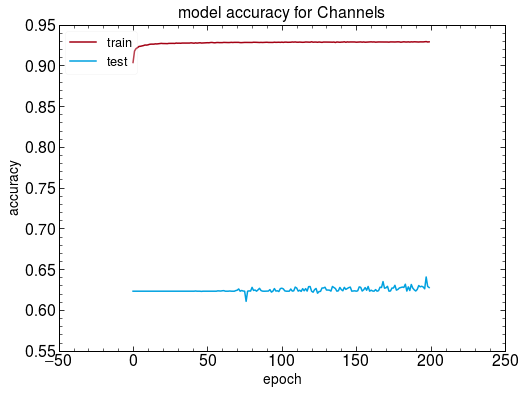

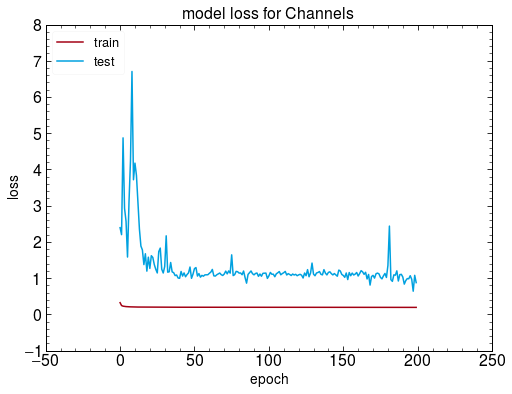

In [66]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_ResNet20v1.history['accuracy'])
    plt.plot(history_ResNet20v1.history['val_accuracy'])
    plt.title('model accuracy for Channels')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_ResNet20v1.history['loss'])
    plt.plot(history_ResNet20v1.history['val_loss'])
    plt.title('model loss for Channels')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

<Figure size 576x432 with 0 Axes>

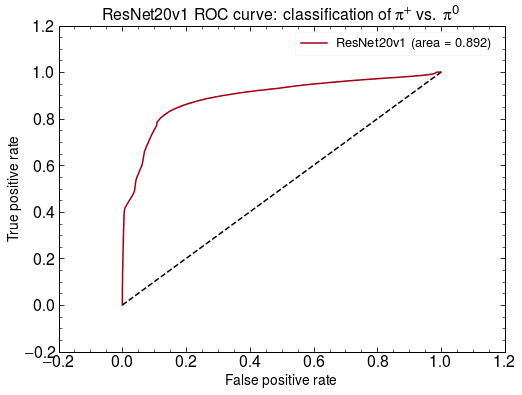

In [68]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_ResNet20v1, roc_tpr_ResNet20v1, label='ResNet20v1 (area = {:.3f})'.format(roc_auc_ResNet20v1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ResNet20v1 ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig(plotpath+'/roc_ResNet20v1.pdf')
plt.show()